In [2]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

In [48]:
%matplotlib inline
import numpy as np
import timeit
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (30,15)

from numba import jit

# Coursework 1

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

## Monte Carlo Methods - the Ising Model

The Ising model is a simplified two-dimensional representation of a magnet. A regular, square, $N \times N$ lattice represents the sites which have individual magnetic *spins*, which are $\pm 1$: so $S_{i,j}$ is the spin at site $(i,j)$. The total energy of the magnet is given by the sum of the nearest-neighbour interaction energies

$$
  \begin{aligned}
    E &= -J \sum_{\text{nearest neighbours}} S_{i_1, j_1} S_{i_2, j_2} \\
      &= -J \sum_{i, j = 0}^{N-1} S_{i, j} \left( S_{i-1, j} + S_{i+1, j} + S_{i, j-1} + S_{i, j+1} \right).
  \end{aligned}
$$

$J$ is the strength of the exchange interaction which we will set to $1$ throughout. Periodic boundaries are used, ie

$$
  \begin{aligned}
    S_{-1, j} &= S_{N-1, j}, \\
    S_{N, j} &= S_{0, j}, \\
    S_{i, -1} &= S_{i, N-1}, \\
    S_{i, N} &= S_{i, 0}.
  \end{aligned}
$$

If the spin of one site $(I, J)$ is flipped then the energy change is

$$
  \Delta E = 2 J S_{I, J} \left( S_{I-1, J} + S_{I+1, J} + S_{I, J-1} + S_{I, J+1} \right).
$$

The total (average) magnetization is

$$
  M = \frac{1}{N^2} \sum_{i, j = 0}^{N-1} S_{i, j}.
$$

### Tasks

1. Write a Metropolis-Hastings algorithm to find the equilibrium state of the Ising model.
2. Using a lattice of $40^2$ sites, show the final state after $2 \times 10^6$ steps using inverse temperatures of $\beta = 0.1$ and $\beta = 1.0$.
3. By computing the equilibrium magnetization for $50$ different values of $\beta \in [0.1, 0.5]$, using a lattice of $20^2$ for $5 \times 10^5$ steps, plot how the magnetization behaves.
4. Briefly discuss your results. Note that the critical temperature for a phase transition corresponds to $\beta_c = \log ( 1 + \sqrt{2} ) / 2$.

### 1) Implementation of Metropolis-Hastings algorithm 

In [236]:
def _test_make_big(S):
    """
    Testing function to assert if 'make_big_matrix' function behaves as expected. 
    The function is not expected to return anything if make_big_matrix runs properly,
    otherwise, assertion errors are raise automatically. 
    
    The funciton is tested to see if it can created a bigger matrix (N+2, N+2)
    which satisfies equality in (1:N+1, 1:N+1), and continuity on boundary conditions.
    
    #Parameters:
    ------------
    
    S - np.array (N, N)
        an (N, N) array containing random values.
        
        
    @Returns:
    ------------
    
    NONE
    
    or
    
    AssertionError if function is not behaving properly.
    """
    #execute the creation of expanded matrix
    N, N2 = S.shape
    S_big = make_big_matrix(S) 
    
    #test proper shape
    assert S_big.shape == (N+2, N+2) 
    print("Assert shape went well.")
    
    #test for a random point, if the values correspond
    n = np.random.randint(N)
    m = np.random.randint(N)
    assert S_big[n+1, m+1] == S[n, m]
    print("Random point is correct.")
    
    #test in middle values are equal to the initial matrix
    assert S_big[1:N+1, 1:N+1].all() == S[:, :].all()
    #test continuity values for BC
    assert S_big[0, 1:N+1].all() == S[N-1, :].all()
    assert S_big[N+1, 1:N+1].all() == S[0, :].all()
    assert S_big[1:N+1, 0].all() == S[:, N-1].all()
    assert S_big[1:N+1, N+1].all() == S[:, 0].all()
    print("Internal & BC are correct.")
    print("Matrix created properly!")


def make_big_matrix(S):
    """
    Function which take an array S contining the spin of N^2 particles, and returns an
    expanded matrix containing values for continuity principle.
    
    #Parameters:
    ------------
    
    S - np.array (N, N)
        an (N, N) array containing spin of N^2 particles (+1 or -1).
        
        
    @Returns:
    ------------
    S_bing - np.array (N+2, N+2)
             an array containing the same values as S in the middle (1:N+1, 1:N+1)
             and continuity principle values on the sides S_big[0, 1:N+1] = S[N-1, :] 
             and so on.
    """
    #get initial shape of S
    N, N2 = S.shape #N & N2 should be the same
    S_big = np.zeros([N+2, N+2])
    
    #assign central values
    S_big[1:N+1, 1:N+1] = S[:, :]
    #assign BC values
    S_big[0, 1:N+1] = S[N-1, :] #left
    S_big[N+1, 1:N+1] = S[0, :] #right
    S_big[1:N+1, 0] = S[:, N-1] #top
    S_big[1:N+1, N+1] = S[:, 0] #down :( 
    
    return S_big


#test make_big on the spot
S_test = np.random.random([5,5])
_test_make_big(S_test)

Assert shape went well.
Random point is correct.
Internal & BC are correct.
Matrix created properly!


In [237]:
def _test_newsystem(N=5):
    """
    Function to test if create_system works properly, as expected to create an (N, N) matrix with
    random values of either 1 or -1 only.
    
    #Parameters
    -----------
    
    N - int
        integer used to create a matrix N X N
        
    
    @Returns
    -----------
    NONE
    
    or
    
    AssertionError if function does not behave as expected. 
    """
    S = create_system(N)
    
    #test shape
    assert S.shape == (N, N)
    print("Shape is correct")
    
    #test all integer
    val_matrix = S.astype("int") == S
    assert val_matrix.all()
    print("All integers.")
    
    #test values or 1 or -1
    assert S.all() <= 1
    assert S.all() >= -1
    assert S.all() != 0
    print("Values -1 or 1.")
     

def create_system(N):
    """
    Function that accepts an integer N, and creates a matrix (N, N) containing either 1 or -1
    using a random distribution.
    
    #Parameters
    -----------
    
    N - int
        integer used to create a matrix N X N
        
    
    @Returns
    -----------
    
    S - np.array (N, N)
        numpy array containg the spins of the particles, as random distributions of +1 or -1.
    """
    
    S = np.random.random([N, N]) #create the matrix with random elements
    S[S < 0.5] = -1 #all the random elements <0.5 are assigned -1
    S[S >= 0.5] = 1 #all all >0.5 are assigned 1
    #0.5 is used as a middle point between 0 & 1, as np.random.random gives values between 0 & 1
    
    return S


#test newsystem on the spot
_test_newsystem()

Shape is correct
All integers.
Values -1 or 1.


In [239]:
def _test_energy(S):
    """Function to test if 'energy' function behaves as expected.
    
    #Paremeters
    -----------
    
    S - np array (N, N)
        array containing the spin of N^2 particles, stored as either 1 or -1
        
    
    @Returns
    -----------
    
    NONE
    
    or
    
    AssertionError if function did not behave as expected.
    """
    
    #test total energy
    N, N2 = S.shape #get the shape
    ET = -4 * N**2 #teoretical minimal energy
    assert ET <= energy(S)
    print("Energy higher than lowest minimum.")
    
    #test correct value
    S_t = [[-1, 1, 1],
           [1, 1, -1],
           [-1, -1, 1]]
    S_t = np.array(S_t)
    E_t = 12
    assert E_t == energy(S_t)
    print("Energy returned corresponds to hand calculations.")

In [240]:
@jit
def energy(S, J=1):
    """Funcion that takes a matrix S containg the spin of N^2 particles, and returns 
    the total energy of the system, as a single number.
    
    #Parameters
    -----------
    
    S - np array (N, N)
        matrix containg the spin of the particles, stored as a random distribution of
        +1 or -1
        
    J - float, set as 1 in this exercise
        strength of the exchange interaction
        
    @Returns
    -----------
    E_t - float
          total energy of the system.
    """
    S_big = make_big_matrix(S) #get the expanded matrix
    N, N2 = S.shape
    E = np.zeros([N, N])
    E_t = 0
    
    #calculate the energy of each point, as a function of it's neighbours 
    """E[:, :] = -S_big[1:N+1, 1:N+1] * (S_big[1:N+1, 0:N] +       #left guy
                                      S_big[1:N+1, 2:N+2] +     #right guy
                                      S_big[0:N, 1:N+1] +       #top guy
                                      S_big[2:N+2, 1:N+1])      #down guy :( sad guy"""
    
    for i in range(N):
        for j in range(N):
            E_t += -(S[i, j]) * (S[((i-1) % N), ((j) % N)] +\
                                 S[((i+1) % N), ((j) % N)] +\
                                 S[((i) % N), ((j-1) % N)] +\
                                 S[((i) % N), ((j+1) % N)])
    #E_t = E.sum() #obtain the total energy of the system
    
    return E_t



In [247]:

#testing the energy function in place
S_test = create_system(5)
_test_energy(S_test)

Energy higher than lowest minimum.
Energy returned corresponds to hand calculations.


In [241]:
def _test_denergy(S, i, j):
    """
    Fucntion that tests the operation of 'denergy', through various operations, 
    in order to observe expected or unexpected behaviours.
    
    Parameters
    -----------
    S - np array (N, N)
        matrix containg the spin of N^2 particles, stored as +1 or -1 randomly assigned.
        
    i - int
        position coordinate of the particle for which energy change is calculated, determines the column
        
    j - int 
        position coordinate of the particle for which energy change is calculated, determines the row
     
     
    @Returns
    ----------
    NONE
    
    or
    
    AssertionError if function did not behave as expected.
    """
    #initiate the funciton
    N, N2 = S.shape
    dE = denergy(S, N, i, j)
    
    assert abs(dE) <=8
    assert (dE % 4) == 0
    print("dE smaller than 8, and multiple of 4.")
    
    #test correct value
    S_t = [[-1, 1, 1],
           [1, 1, -1],
           [-1, -1, 1]]
    S_t = np.array(S_t)
    dEt = -8
    assert denergy(S_t, 3, 1, 2) == dEt
    print("Value return matches hand calculations.")



In [262]:
# @jit   
def denergy(S, N, i, j, J=1):
    """
    Function that takes a matrix S containing the spin of N^2 particles, stored as either 1 or -1
    and returns the change in energy for a given particle with coordinates (i, j), based on 
    neighbours interaction.
    
    #Parameters
    -----------
    S - np array (N, N)
        matrix containg the spin of N^2 particles, stored as +1 or -1 randomly assigned.
    
    N - int
        length of the S array 
        
    i - int
        position coordinate of the particle for which energy change is calculated, determines the column
        
    j - int 
        position coordinate of the particle for which energy change is calculated, determines the row
     
     
    @Returns
    -----------
    dE - float
         the energy change of a particle, when its spin state is flipped. Calculated based on neighbours.
         
    EX:
        |-1 +1 +1|
    S = |+1 -1 -1| => dE = 2 * (-1) + [(+1) + (+1) + (-1) + (+1)] = 4
        |-1 +1 -1|
    """
    
    #calculate the change in energy, using the spin before change
    dE =  2 * (S[i, j]) * (S[((i-1) % N), ((j) % N)] +\
                            S[((i+1) % N), ((j) % N)] +\
                            S[((i) % N), ((j-1) % N)] +\
                            S[((i) % N), ((j+1) % N)])    
    
    return dE


In [250]:
#test the operation of denergy in place
ii, jj = np.random.randint(5, size=2)
_test_denergy(S_test, ii, jj)
denergy(S_test, 5, ii, jj)

[[ 1. -1. -1. -1. -1.]
 [ 1. -1. -1.  1.  1.]
 [ 1. -1. -1. -1. -1.]
 [ 1.  1.  1. -1. -1.]
 [ 1. -1. -1. -1.  1.]]
dE smaller than 8, and multiple of 4.
Value return matches hand calculations.


In [251]:
def _test_magnetisation(S):
    """Method to test the properoperation of 'magnetisation.
    #Parameters
    -----------
    S - np array (N, N) or any format
        an array containing either +1 or -1 assigned randomly in the matrix. They represent the spin
        of the particles
        
    @Returns
    -----------
    NONE
    
    or
    
    AssertionError if function did not behave as expected.
    """
    
    #initialise the function
    N, N2 = S.shape
    M = magnetisation(S, N)
    
    #test magnitude
    assert M >= -1
    assert M <= 1
    print("Magnetisation is between -1 & 1.")
    
    #test value against usual model
    N, N2 = S.shape
    M_f = 0
    for i in range(N):
        for j in range(N):
            M_f += S[i ,j]
    M_f = M_f / N**2
    
    assert M == M_f
    print("M = M_f is correct.")



In [252]:
@jit
def magnetisation(S, N):
    """Function that takes as input an array S with NxN elements, representing the spin of the particles,
    stored as +1 or -1, assigned randomly, and returns the total magentisation of the system.
    
    #Parameters
    -----------
    S - np array (N, N) or any format
        an array containing either +1 or -1 assigned randomly in the matrix. They represent the spin
        of the particles
        
    N - int
        size of the array
        
    @Returns
    -----------
    M - float
        average magnetisation of the system, calculated as the sum of spins divided by their number.
    """
    #get M
    M = S.sum() / N**2
    return M


In [253]:
S_test = create_system(5)
_test_magnetisation(S_test)

Magnetisation is between -1 & 1.
M = M_f is correct.


In [261]:
def _test_EVERYTHING(N=40):
    """
    Function that call all test functions for the building block functions.
    
    #Parameters
    -----------
    N - int
        size of the array to be created and used in the test.
        
    @Returns
    -----------
    NONE
    
    or
    
    AssertionError if function did not behave as expected.
    """
    #test if a new lattice can be created
    _test_newsystem(N)
    
    #get the new lattice
    S = create_system(N)
    
    #test if the big matrix can be created, including the BC
    _test_make_big(S)
    
    #test the energy functionality
    _test_energy(S)
    
    #test denergy
    ii, jj = np.random.randint(N, size=2)
    _test_denergy(S, ii, jj)
    
    #test the magnetisation
    _test_magnetisation(S)
    
    #test the actual model
    _test_ising_model(S)
    
    
_test_EVERYTHING()

Shape is correct
All integers.
Values -1 or 1.
Assert shape went well.
Random point is correct.
Internal & BC are correct.
Matrix created properly!
Energy higher than lowest minimum.
Energy returned corresponds to hand calculations.
dE smaller than 8, and multiple of 4.
Value return matches hand calculations.
Magnetisation is between -1 & 1.
M = M_f is correct.
Energy series exists properly.


In [255]:
def _test_ising_model(S, steps=20, beta=.6):
    """Method to test the proper functionality of 'ising_model function'.
    
    #Parameters
    -----------
    S - np array (N, N)
        array containig the random distribution of spins (+1 or -1) of the particles
        
    steps - int
            set as 20 for the purpose of this exercise
            number of steps the Monte Carlo simulation will execute
    
    beta - float
           set as .6 for this exercise
           inverse temperature of the lattice. Used to calculate probability if change in spin
           is accepted or not.
    
    @Returns
    -----------
    NONE
    
    or
    
    AssertionError if function did not behave as expected.
    """
    E_s, M_s, S_n = ising_model(S, steps=steps, beta=beta)
    
    N, N2 = S.shape
    
    #test Energy series
    Ne, = E_s.shape
    assert Ne == steps
    assert E_s.any() != 0
    print("Energy series exists properly.")
    
    #test Magnetisation series
    """ Nm, = M_s.shape
    assert Nm == steps
    assert abs(M_s).all() <= 1
    assert M_s.any != 0
    print("Magnetisation series exists properly.")
    """
    #test the returned series
    """Ns, Ns2 = S_n.shape
    assert Ns == Ns2
    assert Ns == N
    assert abs(S_n).all() == 1
    print("Spin series returned correctly.")
    """


In [256]:
@jit
def ising_model(S, steps=2*10**6, beta=1):
    """
    Main function of this part of the exercise. It implements and Ising Model over an 
    array S, as a Monte Carlo simulation. The array contains the spin, as +1 or -1. 
    The MC runs for a set number of steps. 
    The function returns 3 parameters: one array containing the energy of the system at each step,
    one array containing the average magnetisation of the system at each step, and an array 
    containing the final spins of the particles, after the MC simulation.
    
    #Parameters
    -----------
    S - np array (N, N)
        array containig the random distribution of spins (+1 or -1) of the particles
        
    steps - int
            set as 2*10^6 for the purpose of this exercise
            number of steps the Monte Carlo simulation will execute
    
    beta - float
           set as 1 for this exercise
           inverse temperature of the lattice. Used to calculate probability if change in spin
           is accepted or not.
           
    @Returns
    E_series - np.array (steps)
               array containing the final energy of the system after each step
               
    M_series - np.array (steps)
               array containing the average magnetisation of the system after each step
               
    S - np array (N, N)
        array containing the spin of the particles after the MC simulation run the number of steps
        provided
    """
    #get shape in array
    N, N2 = S.shape
    
    #initialise the E & M series
    
    M_series = np.zeros(steps)
    
    #in case steps is given as float
    steps = int(steps) 
    #compute initial energy of the system
    E_current = energy(S)
    
    #start MC
    E_series, S = run_mc(S, N, E_current, steps, beta)
        
        
    return (E_series, magnetisation(S, N), S)



In [257]:
@jit
def run_mc(S, N, E_current, steps, beta):   
    E_series = np.zeros(steps)
    for step in range(steps):
        #generate the random position of the spin change
        i, j = np.random.randint(N, size=2)
        
        #apply the change in spin
        #S_new = S.copy()
        #S_new[i, j] *= -1
        #calculate the change in energy
        dE = denergy(S, N, i, j)
        
        #check if change should actually take place. We want the overall energy of the system to decrease
        if ((dE < 0) or (np.exp(-beta * (dE)) > np.random.rand())):
            #assign the change
            S[i, j] *= -1
            E_current += dE
        
        #store the values of energy and magnetisation of this step
        E_series[step] = E_current
    return E_series, S

In [258]:
#test on spot
_test_ising_model(S_test)

Energy series exists properly.


### 2) Data analysis for the cases where beta=0.1 and beta=1.0, along with spin & energy plotting.

In [266]:
def graph_plotting(S, E_ser, beta):
    """
    Function that takes the matrix S of spins and the Energy series, and plots them accordingly:
    the spin lattice as an X VS Y coord of the particle, with +1 and -1 values being shown differently
    and the Energy series as a line graph. 
    
    #Parameters
    -----------
    S - np array (N, N)
        contains the spin of N^2 elements, as either +1 or -1
        
    E_ser - np array (M)
            contains the energy of the lattice after M steps being processed
            in a Monte Carlo simulation
            
    beta - float
           value of the lattice temperature used in the current simulation
           
    @Return
    NONE
    
    However, the function, plots & displays 2 graphs.
    """
    #plots the energy distribution
    print("Spin of particles after 2*10^6 MC run, for beta={}".format(beta))
    plt.figure()
    plt.plot(E_ser, label="Energy")
    plt.xlabel("Steps")
    plt.ylabel("Energy")
    plt.title(r"Energy distribution for $\beta$ = {} during MC iterations".format(beta))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    #plots the spin value of each particle, as a N x N grid. 
    print("Energy variation during the simulation, for beta={}".format(beta))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    i = ax.imshow(S, cmap=plt.cm.seismic, vmin=-1, vmax=1)
    ax.set_xlabel("X position")
    ax.set_ylabel("Y position")
    ax.set_title(r"Particle spin at end of MC sim for $\beta$ = {}".format(beta))
    fig.colorbar(i)

The final energy of the system, after 2*10^6 runs is E=-280.0
The final avearage magnetisation of the system, after 2*10^6 runs is M=-0.05625
Spin of particles after 2*10^6 MC run, for beta=0.1


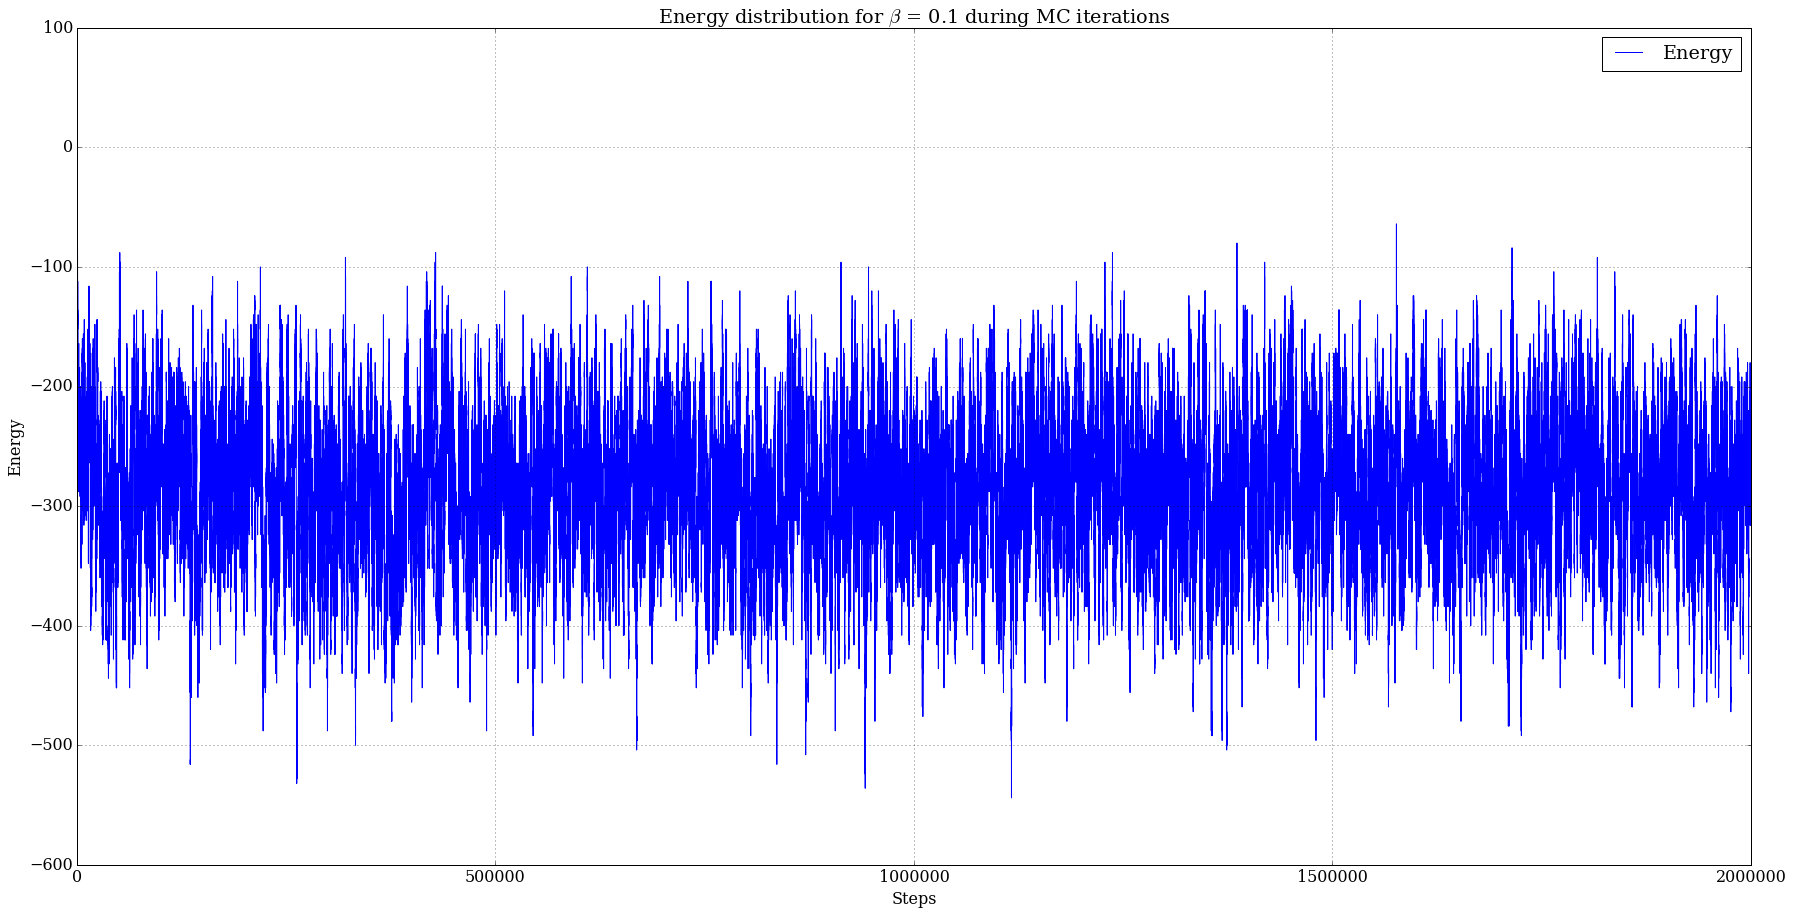

Energy variation during the simulation, for beta=0.1


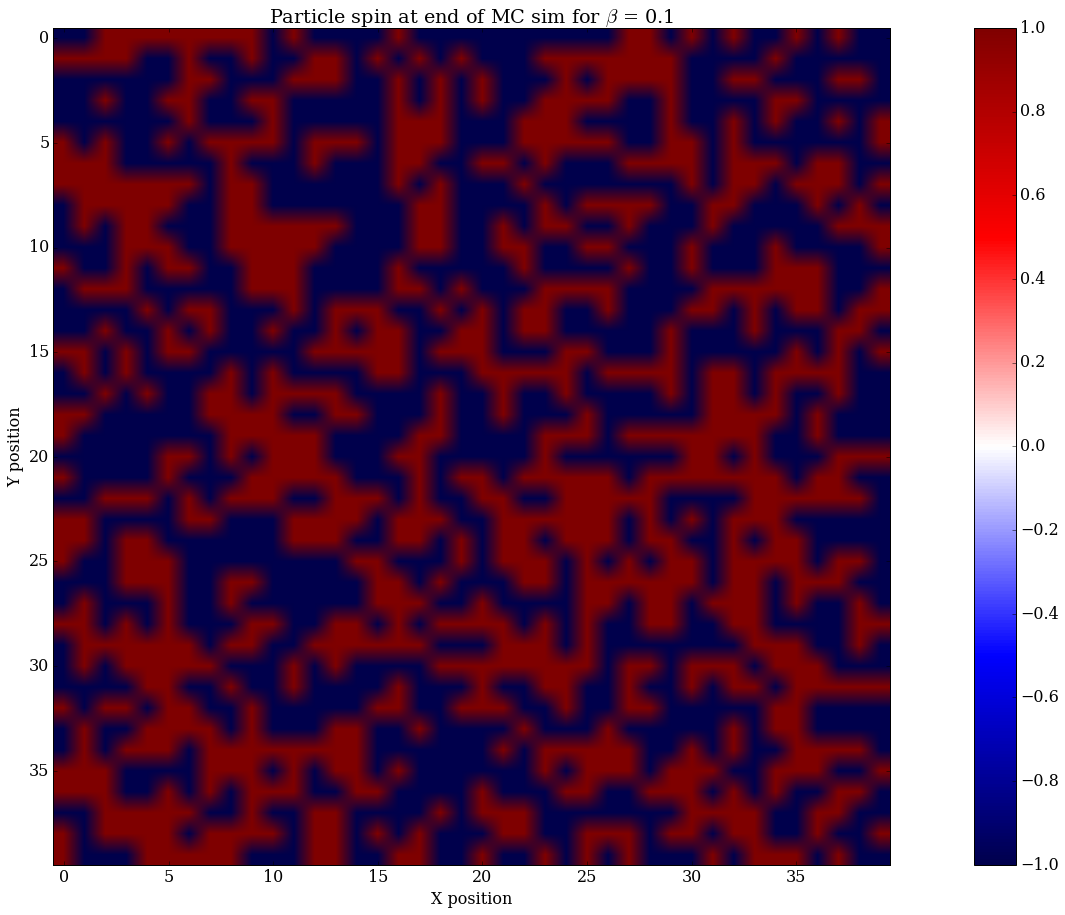

In [267]:
N = 40

#Work the solution for beta=0.1 case
S01 = create_system(N)
beta01 = 0.1
E_ser01, M_ser01, S01 = ising_model(S01, beta=beta01)
print("The final energy of the system, after 2*10^6 runs is E={}".format(E_ser01[-1]))
print("The final avearage magnetisation of the system, after 2*10^6 runs is M={}".format(M_ser01))
graph_plotting(S01, E_ser01, beta01)

The final energy of the system, after 2*10^6 runs is E=-3152.0
The final average magnetisation of the system, after 2*10^6 runs is M=-1.0
Spin of particles after 2*10^6 MC run, for beta=1.0


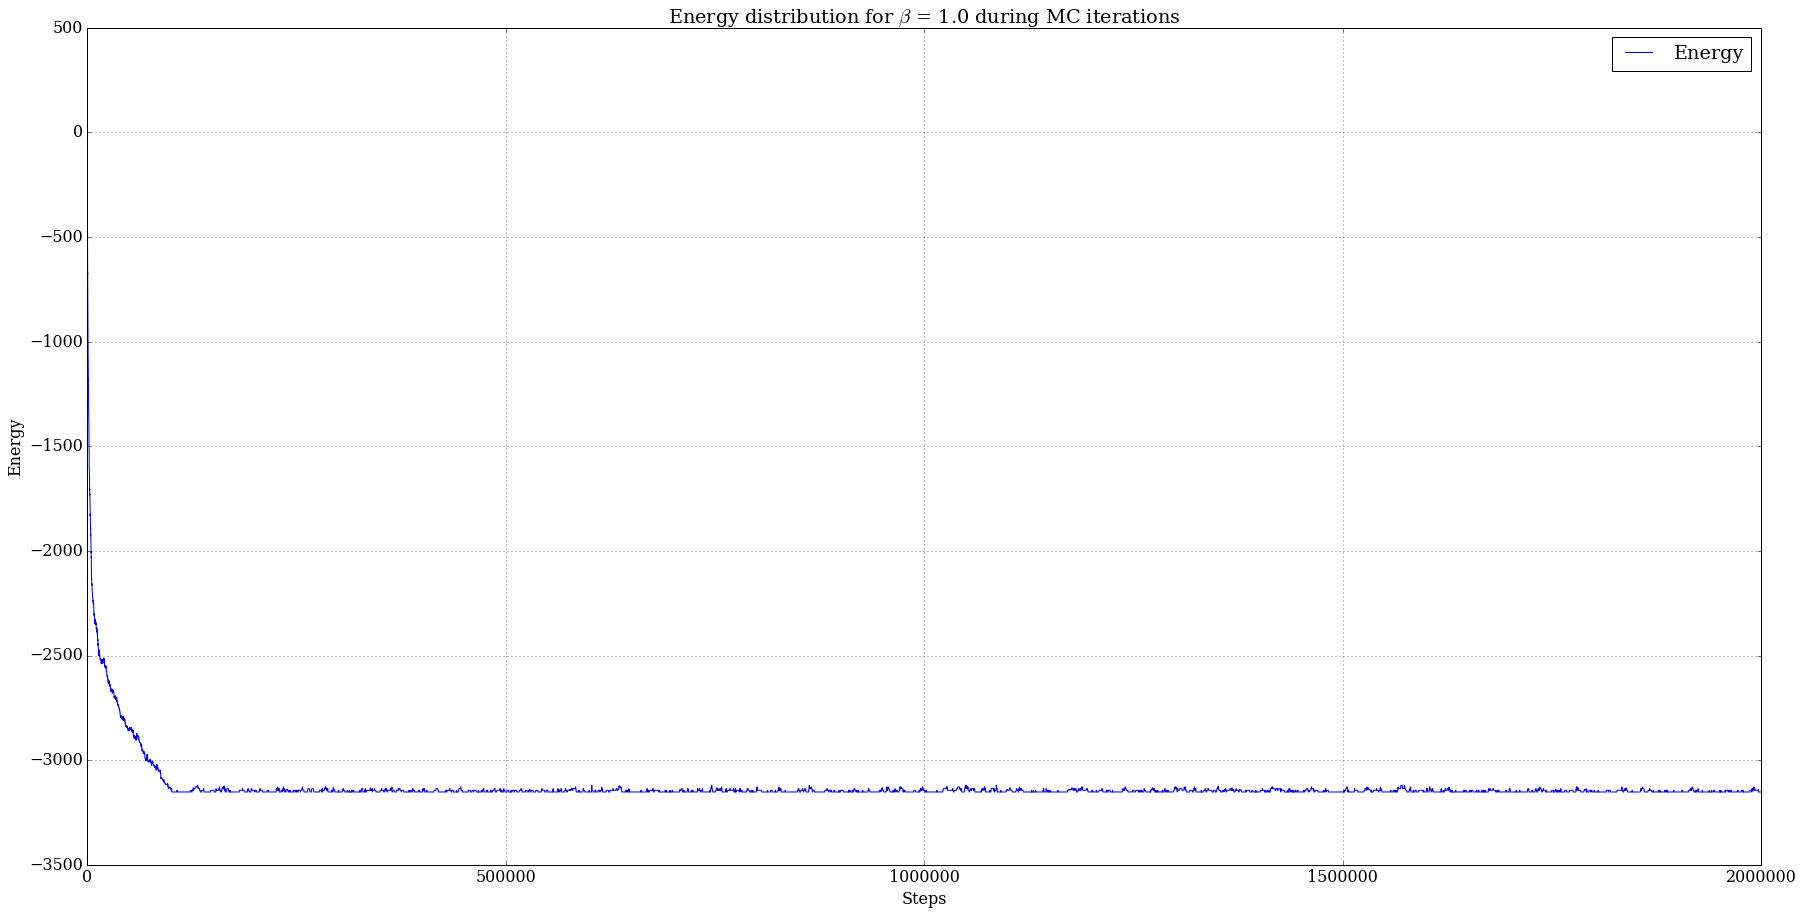

Energy variation during the simulation, for beta=1.0


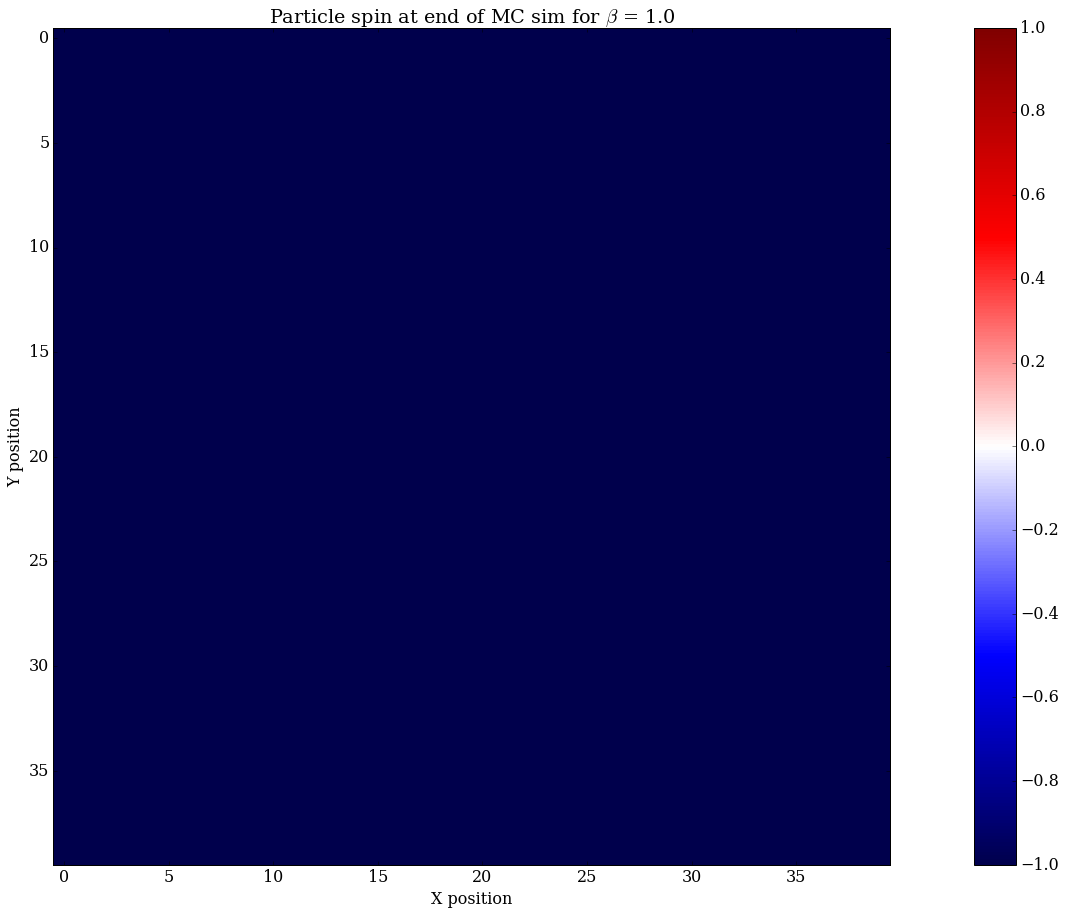

In [268]:
#Work the solution for beta=1 case
S10 = create_system(N)
beta10 = 1.0
E_ser10, M_ser10, S10 = ising_model(S10, beta=beta10)
print("The final energy of the system, after 2*10^6 runs is E={}".format(E_ser10[-1]))
print("The final average magnetisation of the system, after 2*10^6 runs is M={}".format(M_ser10))
graph_plotting(S10, E_ser10, beta10)

### 3) Equilibrium magnetisation for different values of beta

In [269]:
def magnetisation_plotting(M_finals, M_steps):
    """Function that takes 2 arrays containing different magnetisation values of the system,
    and produces graphs for each one.
    
    #Parameters
    -----------
    M_finals - np array (N, 2)
               array containing only the final magnetisation of the system after each monte carlo
               
    M_series - np array (N, M)
               array containng all (M) magnetisations of the system for each value of beta 
               Monte Carlo, at each step in the simulations.
               
    @Return
    ----------
    NONE
    
    However, the function produces 2 graphs."""
    
    bc = np.log(1 + np.sqrt(2)) / 2
    
    #plot the final magnetisation for each beta
    print("Magnetisation value for different values of beta.")
    plt.figure()
    plt.plot(M_finals[:, 0], M_finals[:, 1], "b*", label="Final Magnetisation")
    plt.xlabel(r'$\beta$')
    plt.ylabel("Magnetisation")
    plt.title(r'Magnetisation distribution for different values of $\beta$.')
    plt.legend(loc=2)
    plt.grid(True)
    plt.axvline(x=bc)
    plt.show()
    
    """#plot all the magnetisations at each step for each beta
    print("Magnetisation evolution during MC simulations")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for i in range(M_steps.shape[0]):
        ax1.plot(M_steps[i, :])
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Magnetisation")
    ax1.set_title("Magnetisation evolution during MC simulations")"""

In [270]:
n_beta = 50

beta_full = np.linspace(0.1, 0.5, n_beta).round(6)
N20 = 20

S = create_system(N20)
M_finals = np.zeros([n_beta, 2])
M_steps = np.zeros([n_beta, 5*10**5])
E_series =np.zeros([n_beta, 5*10**5])

print("Initial magnetisation of the system is M = {}".format(magnetisation(S, N20)))

for i in range(n_beta): 
    S_used = S.copy()
    E_step, M_step, S_step = ising_model(S_used, steps=5*10**5, beta=beta_full[i])
    M_finals[i] = [beta_full[i], M_step]
    #M_steps[i, :] = M_step
    #E_series[i, :] = E_step
    print("Magnetisation at beta={} is M = {}.".format(beta_full[i], M_step))

Initial magnetisation of the system is M = 0.04
Magnetisation at beta=0.1 is M = -0.015.
Magnetisation at beta=0.108163 is M = -0.04.
Magnetisation at beta=0.116327 is M = -0.08.
Magnetisation at beta=0.12449 is M = -0.08.
Magnetisation at beta=0.132653 is M = -0.03.
Magnetisation at beta=0.140816 is M = -0.06.
Magnetisation at beta=0.14898 is M = -0.045.
Magnetisation at beta=0.157143 is M = -0.09.
Magnetisation at beta=0.165306 is M = -0.105.
Magnetisation at beta=0.173469 is M = 0.065.
Magnetisation at beta=0.181633 is M = -0.115.
Magnetisation at beta=0.189796 is M = 0.02.
Magnetisation at beta=0.197959 is M = 0.02.
Magnetisation at beta=0.206122 is M = 0.065.
Magnetisation at beta=0.214286 is M = -0.16.
Magnetisation at beta=0.222449 is M = -0.08.
Magnetisation at beta=0.230612 is M = -0.04.
Magnetisation at beta=0.238776 is M = -0.065.
Magnetisation at beta=0.246939 is M = -0.02.
Magnetisation at beta=0.255102 is M = 0.01.
Magnetisation at beta=0.263265 is M = 0.06.
Magnetisation

Magnetisation value for different values of beta.


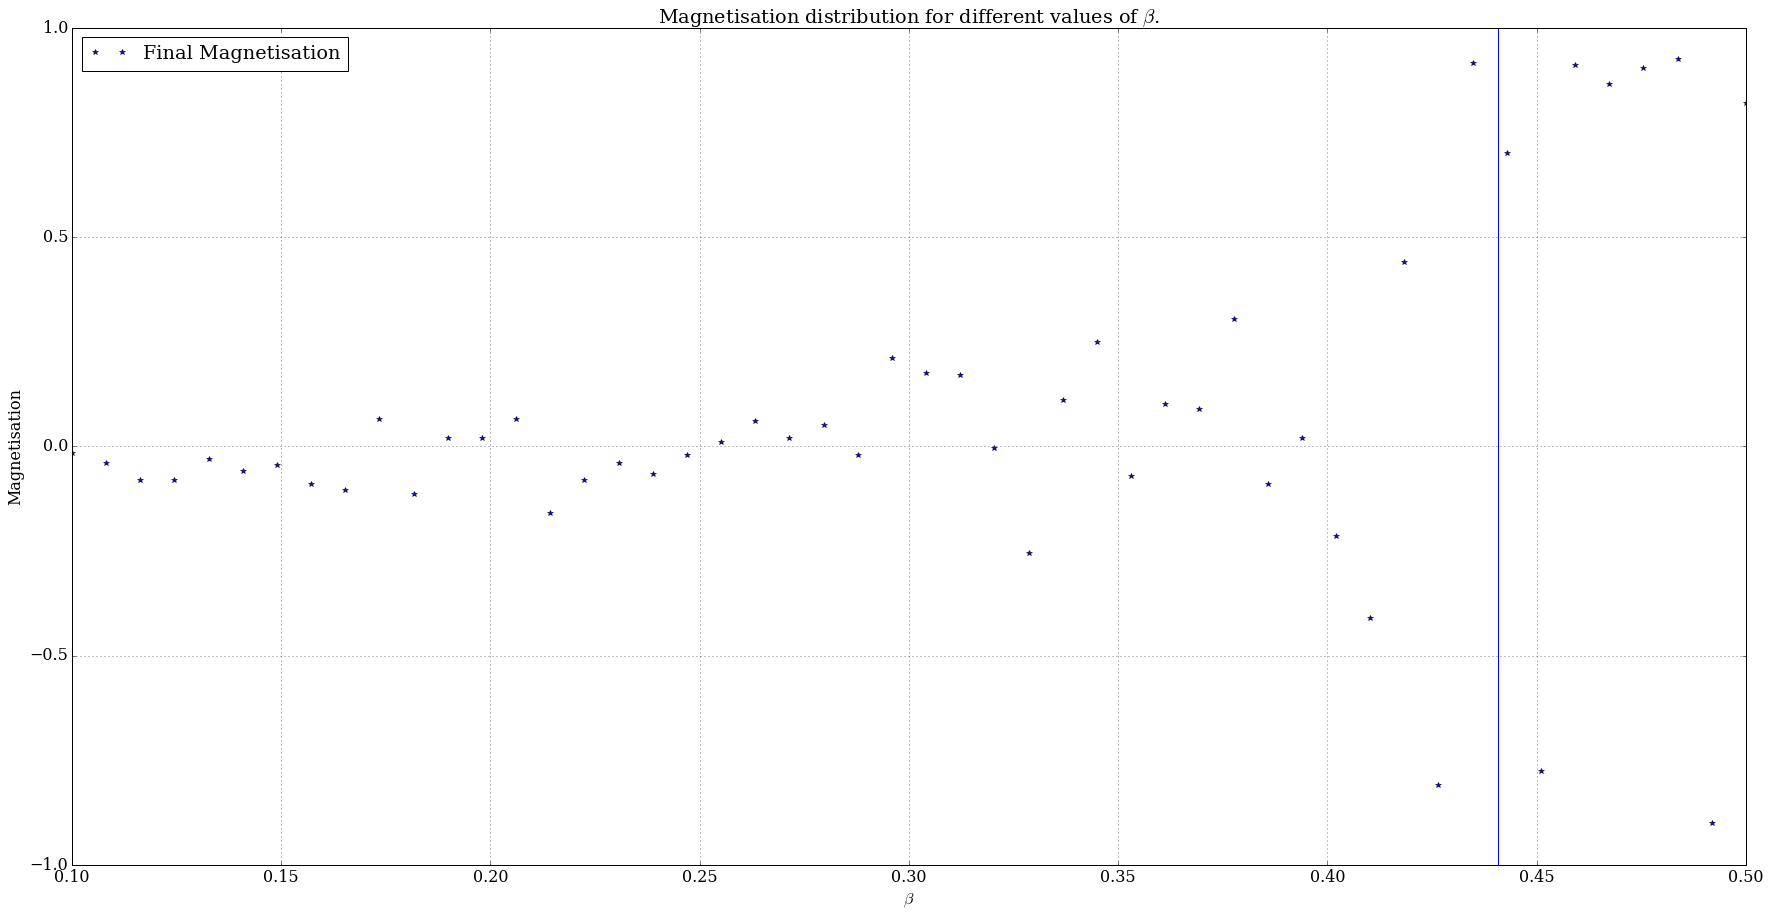

In [271]:
#plotting the average magnetisation
magnetisation_plotting(M_finals, M_steps)

Magnetisation value for different values of beta.


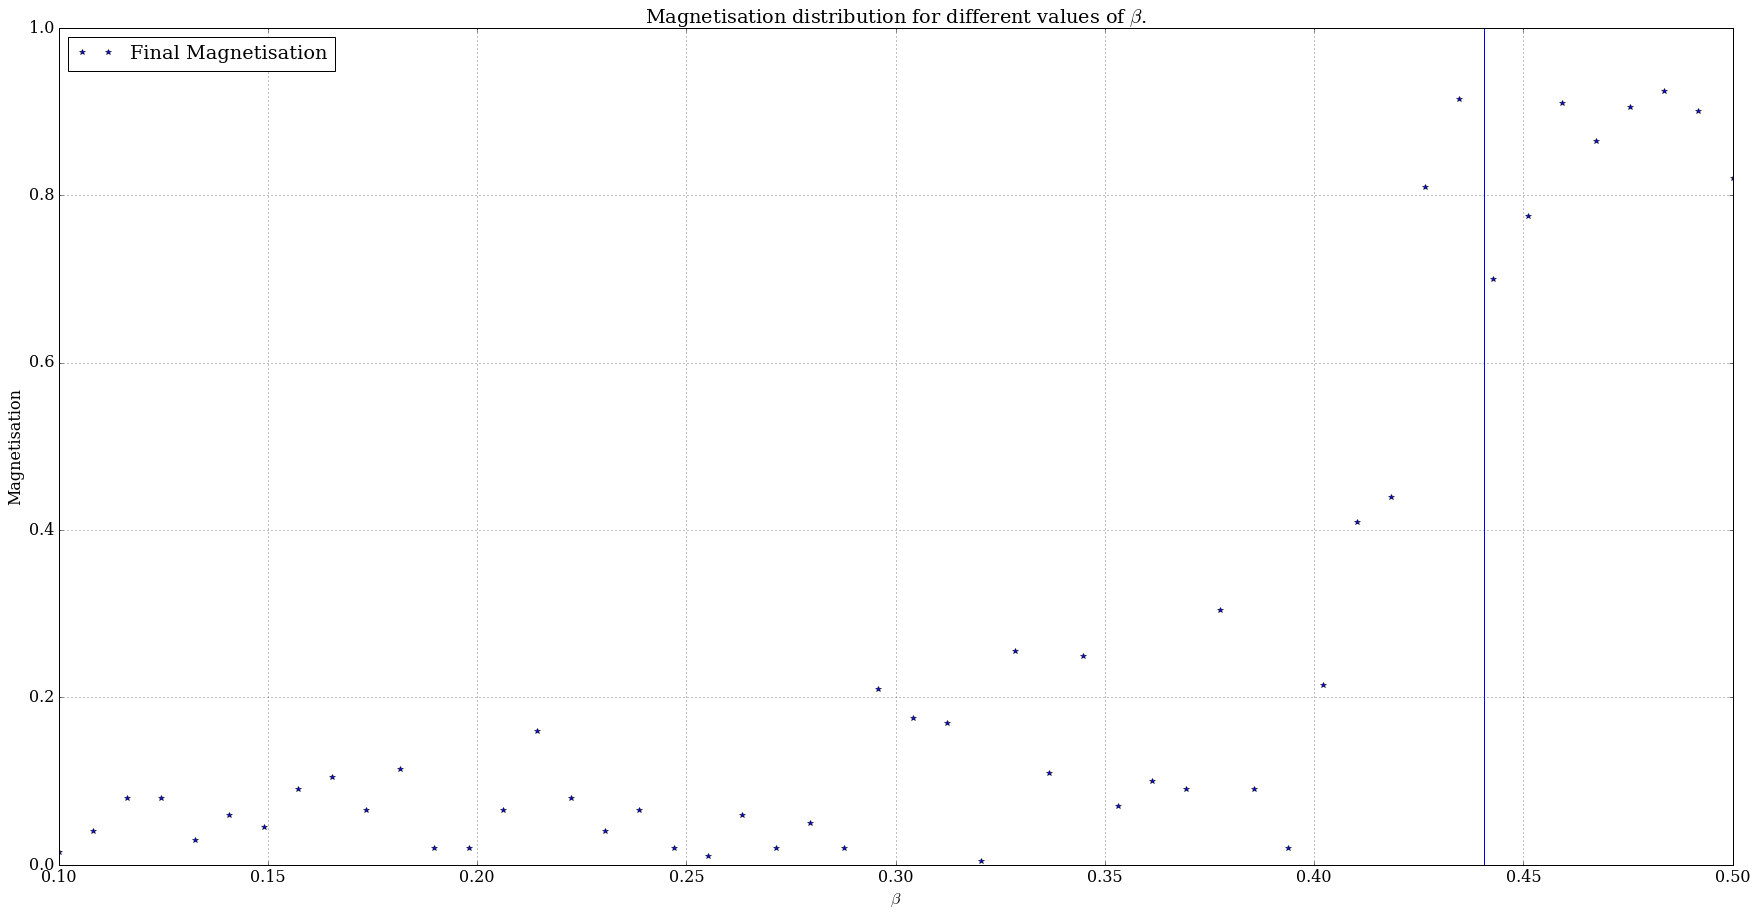

In [272]:
#Plotting the absolute value of final magnetisation
magnetisation_plotting(abs(M_finals), M_steps)

In [273]:
n_beta = 50

beta_full = np.linspace(0.1, 0.5, n_beta).round(6)
N20 = 20

S = create_system(N20)
M_finals = np.zeros([10 , n_beta, 2])
M_steps = np.zeros([n_beta, 5*10**5])
E_series =np.zeros([n_beta, 5*10**5])

print("Initial magnetisation of the system is M = {}".format(magnetisation(S, N20)))

for j in range(10):
    for i in range(n_beta): 
        S_used = S.copy()
        E_step, M_step, S_step = ising_model(S_used, steps=5*10**5, beta=beta_full[i])
        M_finals[j, i, :] = [beta_full[i], M_step]
        #M_steps[i, :] = M_step
        #E_series[i, :] = E_step
        print("Magnetisation at beta={} is M = {}.".format(beta_full[i], M_step))

Initial magnetisation of the system is M = -0.03
Magnetisation at beta=0.1 is M = -0.005.
Magnetisation at beta=0.108163 is M = 0.005.
Magnetisation at beta=0.116327 is M = 0.045.
Magnetisation at beta=0.12449 is M = 0.13.
Magnetisation at beta=0.132653 is M = 0.055.
Magnetisation at beta=0.140816 is M = -0.045.
Magnetisation at beta=0.14898 is M = 0.05.
Magnetisation at beta=0.157143 is M = 0.1.
Magnetisation at beta=0.165306 is M = -0.02.
Magnetisation at beta=0.173469 is M = 0.035.
Magnetisation at beta=0.181633 is M = 0.015.
Magnetisation at beta=0.189796 is M = 0.015.
Magnetisation at beta=0.197959 is M = -0.04.
Magnetisation at beta=0.206122 is M = -0.035.
Magnetisation at beta=0.214286 is M = 0.06.
Magnetisation at beta=0.222449 is M = 0.17.
Magnetisation at beta=0.230612 is M = -0.06.
Magnetisation at beta=0.238776 is M = 0.02.
Magnetisation at beta=0.246939 is M = -0.025.
Magnetisation at beta=0.255102 is M = 0.04.
Magnetisation at beta=0.263265 is M = 0.125.
Magnetisation at 

Magnetisation value for different values of beta.


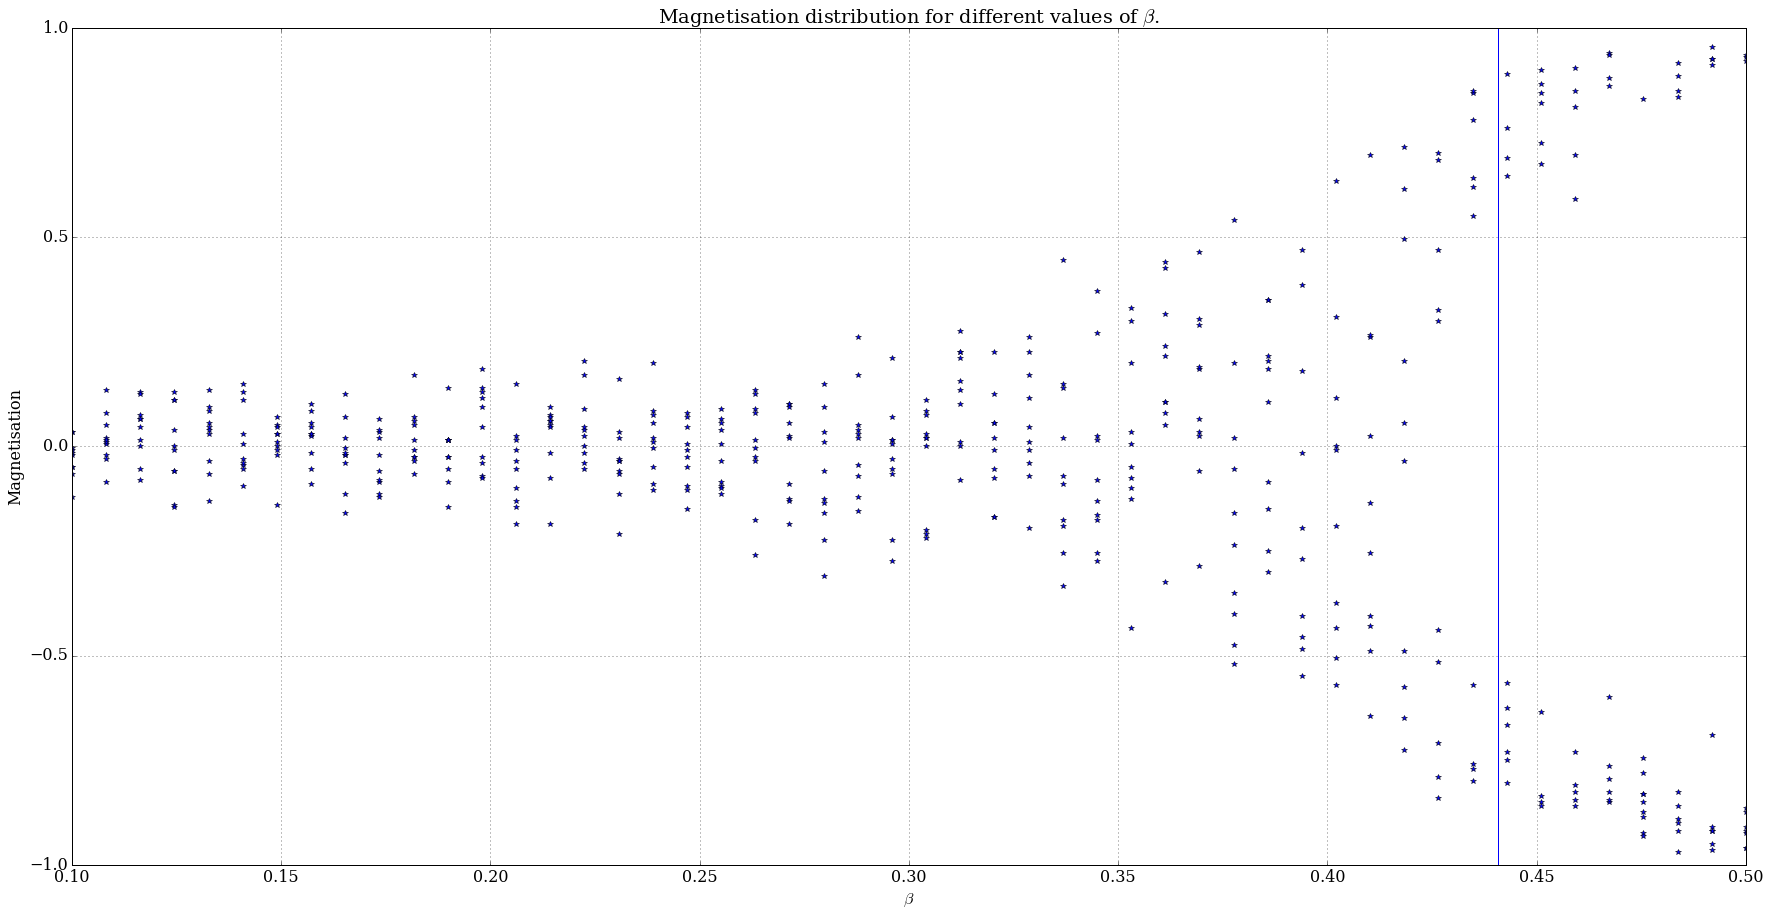

In [274]:
def magnetisation_plotting10(M_finals, M_steps):
    """Function that takes 2 arrays containing different magnetisation values of the system,
    and produces graphs for each one.
    
    #Parameters
    -----------
    M_finals - np array (N, 2)
               array containing only the final magnetisation of the system after each monte carlo
               
    M_series - np array (N, M)
               array containng all (M) magnetisations of the system for each value of beta 
               Monte Carlo, at each step in the simulations.
               
    @Return
    ----------
    NONE
    
    However, the function produces 2 graphs."""
    
    bc = np.log(1 + np.sqrt(2)) / 2
    
    #plot the final magnetisation for each beta
    print("Magnetisation value for different values of beta.")
    plt.figure()
    for i in range(10):
        plt.plot(M_finals[i, :, 0], M_finals[i, :, 1], "b*", label="Final Magnetisation")
    plt.xlabel(r'$\beta$')
    plt.ylabel("Magnetisation")
    plt.title(r'Magnetisation distribution for different values of $\beta$.')
    #pyplot.legend(loc=2)
    plt.grid(True)
    plt.axvline(x=bc)
    plt.show()
    
    """#plot all the magnetisations at each step for each beta
    print("Magnetisation evolution during MC simulations")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for i in range(M_steps.shape[0]):
        ax1.plot(M_steps[i, :])
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Magnetisation")
    ax1.set_title("Magnetisation evolution during MC simulations")"""


    
magnetisation_plotting10(M_finals, M_steps)

### 4) Discussion

The two graphs presenting the final magnetisation of the lattice, at different values of beta, can be seen in the previous section. The blue line shown is the critical temperature for a phase transition, corresponding to $\beta_c = \log ( 1 + \sqrt{2} ) / 2$.

In Section 2, when $\beta$ has low values (0.1), the system does not stabilise after the Monte Carlo simulation. It can be seen in section 2, from the plot of energy, that is oscilates rapidly between 0 and -550, with the majority of the energies being between -150 and -450. However, this is not the minimum energy of the system. In addition, it can be seen from the plot of the spin values, that at the end of the simulation, there are still many particles with different values of spin. Lastly, it can be seen, that equlibrium avearge final magnetisation is not achieved, with the magnetisation value not being equal to +1 or -1. 
When the system stabilises, the average magnetisation should be equal to the dominant spin in the lattice. 
When $\beta$ has a higher value (1.0), the system stabilises at the lowest energy regime, with all spins being the same value (or just 1 spin being different, depending at which step the system converged). This was illustrated in the second part of Section 2. Lastly, it can be seen the magnetisation is equal to the dominant spin. 

In Section 3, the magnetisation of the system has been computed, for different values of $\beta$. The first plot "Magnetisation distribution" presents the values of the average magnetisations, while the second plot presents the absolut value of the magnetisation, with the values representing the average value of magnetisation at the end of the Monte Carlo simulation. It can be seen, that for lower values of $\beta$, the magnetisation is close to 0. This implies that the system is not stable, or has not reached stability yet. As the values of $\beta$ gradually increase, the absolute value of the average magnetisation increases as well. In addition, when the value of $\beta$ is closer, but lower than the critical temperature, the absolute average magnetisation value increases to values closer to one. This behavious suggests that as the temperature increases, the system has an increase probability to stabilise, or to have a dominant spin state. 
The first plot of average magnetisation distribution, also present how the magnetisation behaves. It can be seen that a clear trend emerges. The majority of of the magnetisation values are either positive or negative (negative in this case). Other simulations have shown a positive trend. Additionally, the initial average magnetisation of the system, before the Monte Carlo Simulation, has the same sign as the main branch of the convergence. It can be concluded that this behaviour is due to the initial random distribution of the lattice, suggesting that a higher number of spins in one direction will facilitate in which direction will it be more likely for the system to converge. 
The final graph presents data from 10 simulations of varying $\beta$ between 0.1 and 0.5. With the initial system's magentisation at -0.03 (negative), and the main branch of bagnetisation tending towars negative, the previous conclusion is reinforced. However, a considerable number of simulations converged towards negative magnetisation, thus proving the stochasticity of this method.

## Molecular Dynamics

Take the potential given for *multiple* water molecules

$$
\begin{align}
  V(\vec{r}) & = V_{\text{external}} + \sum_{k=1}^N V_{\text{internal}, k}, \\
  V_{\text{external}} & = \sum_{i>j} \left( \frac{e_i e_j}{4 \pi e_0 r_{ij}} + 4 \epsilon_{ij} \left[ \left( \frac{\sigma_{ij}}{r_{ij}} \right)^{12} - \left( \frac{\sigma_{ij}}{r_{ij}} \right)^6 \right] \right),\\
  V_{\text{internal}, k} & = \left\{ \sum_{l = 1}^2 D_0 \left[ 1 - e^{\alpha \Delta r_{OH_{l_k}}} \right]^2 + \frac{1}{2} k_{\theta} \Delta r_{HH_k}^2 + k_{r \theta} \Delta r_{HH_k} \left( \Delta r_{OH_{1_k}} + \Delta r_{OH_{2_k}} \right)^2 + k_{rr} \Delta r_{OH_{1_k}} \Delta r_{OH_{2_k}} \right\}.
\end{align}
$$

Here $k$ sums over the different water *molecules*, of which there are $N$. The $V_{\text{internal}, k}$ term corresponds to the forces internal to any one individual molecule (couplings between atoms in different molecules should not be considered). The $i, j$ indices sum over all *atoms*, and correspond to the forces coupling the atoms in different molecules.

The definitions of the terms are: $\Delta r_{OH_l} = r_{OH_{\text{eq}}} - r_{OH_l}$ is the stretch in the distance between the oxygen atom and the $l^{\text{th}}$ hydrogen atom $r_{OH_l}$ and its equilibrium value, and $\Delta r_{HH} = r_{HH_{\text{eq}}} - r_{HH_l}$ is the stretch in the distance between the hydrogen atoms. The parameter values are

1. $D_0 = 101.9188$ kcal/mol.
2. $\alpha = 2.567$ $Å^{-1}$
3. $k_{\theta} = 328.645606$ kcal/mol/$Å^2$
4. $k_{r \theta} = -211.4672$ kcal/mol/$Å^2$
5. $k_{rr} = 111.70765$ kcal/mol/$Å^2$
6. $r_{OH_{\text{eq}}} = 1Å$
7. $r_{HH_{\text{eq}}} = 1.633Å$
8. $e_H = 0.41 e_0$
9. $e_O = -0.82 e_0$
10. $\sigma_{OO} = 3.166Å$
11. $\epsilon_{OO} = 0.1554$ kcal/mol
12. $\epsilon_{OH} = \epsilon_{HH} = 0$ kcal/mol
13. $e_0 = 1$ (unit charge)
14. $m_H = 1.008$ eV
15. $m_O = 15.999$ eV.

The final two parameters are the atomic masses needed to convert the forces $\vec{F} = \partial V / \partial {\vec r}$ to accelerations.

The force terms for the external interactions can be directly computed, as the external interaction potential is in the simplest pairwise form, with

$$
  \frac{d V_{\text{external}, i, j}}{d r_{ij}} = -\frac{e_i e_j}{4 \pi e_0 r_{ij}^2} - 24\sigma_{ij}\epsilon_{ij} \left[ 2 \left( \frac{\sigma_{ij}}{r_{ij}} \right)^{14} - \left( \frac{\sigma_{ij}}{r_{ij}} \right)^8 \right]
$$

and so

$$
  \vec{F}_{\text{external}, i} = \sum_{i>j} (\vec{r}_i - \vec{r}_j) \frac{d V_{\text{external}, i, j}}{d r_{ij}} - \sum_{i<j} (\vec{r}_j - \vec{r}_i) \frac{d V_{\text{external}, i, j}}{d r_{ij}}.
$$

Use a cut-off radius $R_c = 5Å$ for the external pairwise interactions.

The force terms for the internal interactions are best constructed automatically.

### Setup

Consider a box with periodic boundaries. Each box will have $\vec{x} \in [0, 7Å]^3$.

Put eight water molecules in the box. The locations of the oxygen atoms should be on the corners of a cube, forming a regular lattice. Therefore the coordinate locations should either be $1.75Å$ or $5.25Å$ for every component:

$$
\begin{aligned}
  \vec{r}_{O_1} &= [ 1.75, 1.75, 1.75 ], & \vec{r}_{O_2} &= [ 5.25, 1.75, 1.75 ], \\
  \vec{r}_{O_3} &= [ 1.75, 5.25, 1.75 ], & \vec{r}_{O_4} &= [ 1.75, 1.75, 5.25 ], \\
  \vec{r}_{O_5} &= [ 5.25, 5.25, 1.75 ], & \vec{r}_{O_6} &= [ 5.25, 1.75, 5.25 ], \\
  \vec{r}_{O_7} &= [ 1.75, 5.25, 5.25 ], & \vec{r}_{O_8} &= [ 5.25, 5.25, 5.25 ].
\end{aligned}
$$

The hydrogen atoms should be located at

$$
\begin{equation}
  \vec{r}_{H_{\pm_k}} = \vec{r}_{O_k} + [ \pm 0.8, 0.6, 0].
\end{equation}
$$

### Tasks

1. Construct a molecular dynamics code to evolve the water molecules. You will probably want to use `sympy` to construct the internal force terms.
2. Using a timestep $\Delta t = 0.001$ evolve to $t=5$ and plot the temperature. Also plot how the location of one of the molecules varies with time. Remember the temperature is

$$
  T = \frac{L^2}{3 N} \sum | \vec{v}_i |^2
$$

where $N$ is the number of atoms and $\vec{v}_i$ the velocity of the $i^{\text{th}}$ atom.

In [4]:
import sympy
sympy.init_printing()

### Initialise constants and produce the equations for internal and external potentials

In [5]:
#variables initialisation
D_0 = 101.9188  #kcal/mol
e0 = 1. #eV
alpha = 2.567 #A
k_theta = 328.645606 #kcal/mol/ Å2
kr_theta = -211.4672 #kcal/mol/ Å2
kr_r = 111.70765 #kcal/mol/ Å2
r_OHeq = 1 #Å
r_HHeq = 1.633#Å
e_H = 0.41 * e0 #eV
e_O = -0.82 * e0 #eV
sigma_OO = 3.166 #Å
epsilon_OO = 0.1554 #kcal/mol
epsilon_OH = epsilon_HH = 0 #kcal/mol
MO = 15.999 #atomic mass of oxygen
MH = 1.008#atomic mass of hydrogen
NA = 6.0221e+23 #avogadro's number

L = 7.
Rc = 5.

dt = 0.001
t = 5

In [6]:
#create x & y & z for O, H1, H2
xO = sympy.symbols('x_O')
yO = sympy.symbols('y_O')
zO = sympy.symbols('z_O')
xH1 = sympy.symbols('x_H_1')
yH1 = sympy.symbols('y_H_1')
zH1 = sympy.symbols('z_H_1')
xH2 = sympy.symbols('x_H_2')
yH2 = sympy.symbols('y_H_2')
zH2 = sympy.symbols('z_H_2')

r_ij = sympy.symbols('r_ij')
e_i = sympy.symbols('e_i')
e_j = sympy.symbols('e_j')
epsilon_ij = sympy.symbols('epsilon_ij')
sigma_ij = sympy.symbols('sigma_ij')


#get the distances
dr_HH = sympy.sqrt((xH2 - xH1)**2 + (yH2 - yH1)**2 + (zH2 - zH1)**2) - r_HHeq
dr_OH1 = sympy.sqrt((xO - xH1)**2 + (yO - yH1)**2 + (zO - zH1)**2) - r_OHeq
dr_OH2 = sympy.sqrt((xO - xH2)**2 + (yO - yH2)**2 + (zO - zH2)**2) - r_OHeq

#create the equation of the potential
V_int = D_0 * ((1 - sympy.exp(alpha * dr_OH1))**2 + (1 - sympy.exp(alpha * dr_OH2))**2) + \
    (k_theta * dr_HH**2) / 2 + kr_theta * dr_HH * (dr_OH1 + dr_OH2)**2 +\
    kr_r * dr_OH1 * dr_OH2
    
sr6 = (sigma_ij / r_ij)**6
V_ext = e_i * e_j / (4 * sympy.pi * e0 * r_ij) + 4 * epsilon_ij * (sr6**2 - sr6)


In [190]:
def _test_setup():
    """Function to test the proper functionality of 'setup_particles' function.
    
    #Parameters
    NONE
    
    @returns
    NONE
    
    Unless setup_particles is not functionaing as expected, then it will return assertion errors.
    """
    r = setup_particles()
    
    n, a = r.shape
    assert n == 24
    assert a == 3
    
    for i in range(8):
        assert (r[i*3, :] % 1.75).all() == 0 #test the oxygen position
        assert (r[i*3, :] - r[i*3+1, :] - [-0.8, 0.6, 0]).all() == 0 #left hydrogen
        assert (r[i*3, :] - r[i*3+2, :] - [+0.8, 0.6, 0]).all() == 0 #right hydrogen
    
    print("Test complete.")

def setup_particles():
    """
    Function that creates the particle setup, for the 8 water molecules. Returns an array containing 
    containing the initial position of the oxygen and hydrogen atoms. 
    
    #Parameters
    ------------
    NONE
    Function takes no parameters.
    
    @Returns
    r - np array (8 3 3)
        numpy array containing the position of the 8 molecules, as the positions of
        each individual atom in the particle.
        the middle list in each of the 8 arrays is the oxygen atom, while the other 2 are the hydrogen atoms
    """
    
    r = np.zeros([8,3,3])
    
    #create the oxygen atoms
    r[0, 0, :] = [1.75, 1.75, 1.75] #O_1
    r[1, 0, :] = [5.25, 1.75, 1.75] #O_2
    r[2, 0, :] = [1.75, 5.25, 1.75] #O_3
    r[3, 0, :] = [1.75, 1.75, 5.25] #O_4
    r[4, 0, :] = [5.25, 5.25, 1.75] #O_5
    r[5, 0, :] = [5.25, 1.75, 5.25] #O_6
    r[6, 0, :] = [1.75, 5.25, 5.25] #O_7
    r[7, 0, :] = [5.25, 5.25, 5.25] #O_8
    
    #create the hydrogen atoms around
    r[:, 1, :] = r[:, 0, :] + [+0.8, 0.6, 0]
    r[:, 2, :] = r[:, 0, :] + [-0.8, 0.6, 0]
    
    return r.reshape([24, 3])

_test_setup()

r = setup_particles()

Test complete.


In [186]:
def _test_separation_mag(r):
    """
    Function to test the proper functionality of 'separation_mag' function
    
    #Parameters
    r - np array (N, 3)
        array of floats containing the position of the particles in the system
        
     @returns
    NONE
    
    Unless setup_particles is not functionaing as expected, then it will return assertion errors.
    """
    rij = separation_mag(r)
    
    n1, n2 = r.shape
    N1, N2 = rij.shape
    
    #test shape
    assert (N1 == N2)
    assert (N1 == n1)
    
    #test value
    for i in range(N1):
        for j in range(N2):
            if (i >= j):
                assert (rij[i, j] == 0)
                
    for i in range(10):
        i = np.random.randint(1, N1)
        j = np.random.randint(1, N1)
        while j < i:
            j = np.random.randint(1, N1)
        vec = r[j, :] - r[i, :]
        val = round(np.sqrt(np.dot(vec, vec)), 15)
        assert (val == rij[i, j])
    print("Test complete")

@jit   
def separation_mag(r):
    """
    Function that takes the position of the particles and returns the magnituted of the distance between the 
    particles.
    
    #Parameters
    -----------
    r - np array (24, 3)
        array of floats containing the position of the particles in the system
        
    @Returns
    -----------
    rij - np array (24 24)
        array of floats containing the distance between points i & j. The distances are stored
        just on the upper diagonal.
    """
    n1, n2 = r.shape
    assert (n1 == 24)
    assert (n2 == 3)
    #create the empty matrix
    rij = np.zeros([n1, n1])
    
    #parse through each value
    for i in range(n1):
        for j in range(i+1, n1):
            rij[i, j] = np.sqrt(((r[j, :] - r[i, :])**2).sum()) #get the elements squared, summed & squared rooted
    
    return np.round(rij, decimals=15)

In [188]:
#test separation_mag

test_r = np.random.random([24, 3])
_test_separation_mag(test_r)

Test complete


In [189]:
def _test_separation_vector(r, L, Rc):
    """
    Function to test the proper functionality of 'separation_vector'.
    
    #Parameters
    -----------
    r - np array (N, 3)
        array of floats containing the position of the particles in the system
        
    @returns
    -----------
    NONE
    
    Unless setup_particles is not functionaing as expected, then it will return assertion errors.
    """
    N1, N2 = r.shape
    for i in range(10):
        #test shape
        j = np.random.randint(0, N1)
        dx = separation_vector(r, j, L, Rc)
        assert (dx.shape == r.shape)
        
        #test values
        assert(dx[j].all() == 0)
        k = np.random.randint(0, N1)
        assert((dx[k] - (r[k] - r[j])).all() == 0)
        assert(abs(dx).all() < Rc)
    print("Test complet.")
    
@jit
def separation_vector(pts, i, L, Rc):
    """
    Function that calculates the separation between 1 particle 
    and the other particles in an array.
    
    #parameters
    pts - np array [N, 3] containing the current position of particles,
            wrt an origin at [0,0,0]
    
    i - the cursor position of the particle that will is compared 
            with the other particles
            
    L - the length of the box in which the particles are contained
    
    Rc - 
    @returns
    dx - the separation between the particles as an np array size [N, 3]
    """
    N1, N2 = pts.shape
    assert(i<N1)
    assert(N2 == 3)
    assert(Rc < L)
    
    dx = pts[:, :] - pts[i, :] #gets initial separation by simple substraction
    if dx.any() > Rc:
        print("BOOM")
    dx[np.abs(dx) > Rc] -= np.sign(dx[np.abs(dx) > Rc]) * L 
    """in case the distance between particles is bigger than RC, 
    continuity applies and there is another particle on the other side 
    of the box which has the same properties"""
    return dx

In [192]:
#test spearation_vector
_test_separation_vector(test_r, L, Rc)

Test complet.


#### Create the force model from the potential

In [12]:
#create the internal forces on the OXYGEN by using the derivative of the potential
F_O = (-V_int.diff(xO), -V_int.diff(yO), -V_int.diff(zO))

#create the actual function
f_O = sympy.lambdify((xO, yO, zO, xH1, yH1, zH1, xH2, yH2, zH2), F_O, "numpy")

In [193]:
@jit
def fO_int(rO, rH1, rH2):
    """
    Function that computes the internal forces due to potential inside a molecule of Water. 
    This function calculates the forces of X, Y, Z axis for the OXYGEN atoms.
    
    #Parameters
    ------------
    rO - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the oxygen atom
        
    rH1 - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the first hydrogen atom
        
    rH2 - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the second hydrogen atom
        
    #Returns
    ------------
    fO_int - np array (1, 3)
            np array containing the value of the forces on X, Y & Z due to internal potential 
            for the OXYGEN atom
    """
    NrO, = rO.shape
    NrH1, = rH1.shape
    NrH2, = rH2.shape
    #get the correct  inputs
    assert(NrO == 3)
    assert(NrH1 == 3)
    assert(NrH2 == 3)
    
    return np.array(f_O(rO[0], rO[1], rO[2], rH1[0], rH1[1], rH1[2], rH2[0], rH2[1], rH2[2]))

In [196]:
#testing fO_int
fO_int(r[0], r[1], r[2])

array([ -1.28053422e-13,  -5.31359409e-13,   0.00000000e+00])

In [14]:
#create the internal forces on the HYDROGEN 1 by using the derivative of the potential
F_H1 = (-V_int.diff(xH1), -V_int.diff(yH1), -V_int.diff(zH1))

#create the actual function
f_H1 = sympy.lambdify((xO, yO, zO, xH1, yH1, zH1, xH2, yH2, zH2), F_H1, "numpy")

In [197]:
@jit
def fH1_int(rO, rH1, rH2):
    """
    Function that computes the internal forces due to potential inside a molecule of Water. 
    This function calculates the forces of X, Y, Z axis for the FIRST HYDROGEN atom.
    
    #Parameters
    ------------
    rO - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the oxygen atom
        
    rH1 - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the first hydrogen atom
        
    rH2 - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the second hydrogen atom
        
    #Returns
    ------------
    fO_int - np array (1, 3)
            np array containing the value of the forces on X, Y & Z due to internal potential 
            for the FIRST HYDROGEN atom
    """
    NrO, = rO.shape
    NrH1, = rH1.shape
    NrH2, = rH2.shape
    #get the correct  inputs
    assert(NrO == 3)
    assert(NrH1 == 3)
    assert(NrH2 == 3)
    
    return np.array(f_H1(rO[0], rO[1], rO[2], rH1[0], rH1[1], rH1[2], rH2[0], rH2[1], rH2[2]))

In [201]:
#testing fH1_int
fH1_int(r[0], r[1], r[2])

array([  1.08453050e+01,   3.13699738e-13,   0.00000000e+00])

In [16]:
#create the internal forces on the HYDROGEN 2 by using the derivative of the potential
F_H2 = (-V_int.diff(xH2), -V_int.diff(yH2), -V_int.diff(zH2))

#create the actual function
f_H2 = sympy.lambdify((xO, yO, zO, xH1, yH1, zH1, xH2, yH2, zH2), F_H2, "numpy")

In [202]:
@jit
def fH2_int(rO, rH1, rH2):
    """
    Function that computes the internal forces due to potential inside a molecule of Water. 
    This function calculates the forces of X, Y, Z axis for the SECOND HYDROGEN atoms.
    
    #Parameters
    ------------
    rO - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the oxygen atom
        
    rH1 - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the first hydrogen atom
        
    rH2 - np array (1, 3)
        np array containing the coordinate positions on X, Y & Z for the second hydrogen atom
        
    #Returns
    ------------
    fO_int - np array (1, 3)
            np array containing the value of the forces on X, Y & Z due to internal potential 
            for the SECOND HYDROGEN atom
    """
    NrO, = rO.shape
    NrH1, = rH1.shape
    NrH2, = rH2.shape
    #get the correct  inputs
    assert(NrO == 3)
    assert(NrH1 == 3)
    assert(NrH2 == 3)
    
    return np.array(f_H2(rO[0], rO[1], rO[2], rH1[0], rH1[1], rH1[2], rH2[0], rH2[1], rH2[2]))

In [204]:
#testing fH2_int
fH2_int(r[0], r[1], r[2])

array([ -1.08453050e+01,   2.17659671e-13,   0.00000000e+00])

In [205]:
@jit
def dV_ext_OO(rij):
    """
    Function that calculates the external force due to potential between the OXYGEN atoms
    
    #Parameters
    ------------
    rij - float
            float defining the magnitude of the distance between 2 oxygen atoms.
            
    @Returns
    ------------
    Fext - float
            the magnitude of the unit force vector to be multipled by the vector of the distance between
            the the atoms to obtain the external force on X, Y, Z axis.
    """
    #test rij
    assert(rij > 0)
    assert(rij < L * np.sqrt(3) )
    
    or2 = (sigma_OO / rij)
    return - e_O**2 / (4 * np.pi * e0 * rij**2) - 24 * sigma_OO * epsilon_OO * ((2 * or2**14) - (or2**8))

In [209]:
#testing dV_ext_OO
test_rij = separation_mag(r)
dV_ext_OO(test_rij[0, 7])

In [210]:
@jit
def dV_ext(rij, e1, e2):
    """
    Function that calculates the external force due to potential between the OXYGEN & HYDROGEN atoms or
    HYDROGEN & HYDROGEN atoms
    
    #Parameters
    ------------
    rij - float
            float defining the magnitude of the distance between 2 oxygen atoms.
    e1 - float
        e value for the first of the 2 particles
    
    e2 - float
        e value for the second of the 2 particles
            
    @Returns
    ------------
    Fext - float
            the magnitude of the unit force vector to be multipled by the vector of the distance between
            the the atoms to obtain the external force on X, Y, Z axis.
    """
    #test rij
    assert(rij > 0)
    assert(rij < L * np.sqrt(3) )
    
    #test good e1 & e2
    assert(e1 == e_H or e1 == e_O)
    assert(e2 == e_H or e2 == e_O)
    
    return -e1 * e2 / (4 * np.pi * e0 * rij**2)

In [211]:
#testing dV_ext
dV_ext(test_rij[0,7], e_H, e_O)

In [214]:
def _test_sum_forces(r):
    """
    Function that test the functionality of 'sum_forces' function.
    
    #Parameters
    r - np array (N, 3)
        array containing the position of the particles, at a step. Each row containg the position
        (float) on each of the X, Y, Z axis
        
    @Returns
    ------------
    F - np array (24, 3)
        array containing the forces of each particle on each of the X, Y, Z axis. On each axis, 
        it summs the internal & the external forces due to potential difference.  
    """
    
    rij = separation_mag(r)
    Np, Nd = r.shape
    
    #test for a matrix full of zeros
    F1 = np.zeros([Np, Nd])
    F = sum_force(r, rij, F1)
    assert((F - F1).all() != 0)
    assert(F.shape == Np, Nd)
    for i in range(Nd):
        assert(F[:, i].all() != 0)
    
    #test for a random generated matrix
    F2 = np.random.random([Np, Nd])
    F = sum_force(r, rij, F2)
    assert((F - F2).all() != 0)
    assert(F.shape == Np, Nd)
    for i in range(Nd):
        assert(F[:, i].all() != 0)
    
    print("Test complete.")
    
    
_test_sum_forces(r)

Test complete.


<ipython-input-214-b7c364ad2450>:24: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(F.shape == Np, Nd)
<ipython-input-214-b7c364ad2450>:32: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(F.shape == Np, Nd)


In [219]:
@jit
def sum_force(r, rij, F, internal=1, external=1):
    """
    Function that takes the current position of the particles, the distance between them 
    and a matrix F, and returns an array containing the force on each particle, on each axis,
    due to internal and external potential.
    
    #Parameters
    ------------
    r - np array (24, 3) expected
        array containing the position of the particles, at a step. Each row containg the position
        (float) on each of the X, Y, Z axis
        
    rij - np array (24, 24) expected
        array containing on the upper diagonal the magnitude of the distance between each particle
        and the others
        
    F - np array (24, 3)
        array containing the forces of each particle on each of the X, Y, Z axis.
        given so it will not be created each time the iteration
        
    @Returns
    ------------
    F - np array (24, 3)
        array containing the forces of each particle on each of the X, Y, Z axis. On each axis, 
        it summs the internal & the external forces due to potential difference.
    """
    
    Np, Nd = r.shape
    Ni, Ni2 = rij.shape
    Nf, Nf2 = F.shape
    
    assert(Np == Ni and Np == Ni2)
    assert(Np == Nf)
    assert(Nd == Nf2)
    assert(r.all() > 0 and r.all() < L)
    assert(rij.all() >= 0 and rij.all() < L * np.sqrt(3))
    
    F_new = F.copy()
    #calculate the interior bits
    if internal == 1:
        for i in range(int(Np/Nd)):
            F_new[i*Nd, :] = fO_int(r[i*Nd, :], r[i*Nd+1, :], r[i*Nd+2, :])
            F_new[i*Nd+1, :] = fH1_int(r[i*Nd, :], r[i*Nd+1, :], r[i*Nd+2, :])
            F_new[i*Nd+2, :] = fH2_int(r[i*Nd, :], r[i*Nd+1, :], r[i*Nd+2, :])
    
    #calculate the exterior interactions
    if external == 1:
        for i in range(Ni-3):
            dr = separation_vector(r, i, L, Rc)
            for j in range(((i // 3) + 1) * 3 , Ni):
                if (i % Nd) == 0 and (j % Nd) == 0:
                    #when both are oxygen
                    fact = dV_ext_OO(rij[i, j])
                elif (i % Nd) == 0 or (j % Nd) == 0:
                    #when oxygen & hydrogen
                    fact = dV_ext(rij[i, j], e_H, e_O)
                else:
                    #when hydrogen & hydrogen
                    fact = dV_ext(rij[i, j], e_H, e_H)
            
                F_new[i, :] += dr[j, :] * fact #!!!DONT TOUCH!!! PLUS
                F_new[j, :] -= dr[j, :] * fact #!!!DONT TOUCH SIGNS!!! MINUS
            
        if dr.any() > 5:
            print("boom")
    
    return np.round(F_new, decimals=15)



In [221]:
sum_force(r, test_rij, np.zeros([24, 3]))

array([[  4.43155702e-01,   4.49255957e-01,   4.42319625e-01],
       [  1.08441914e+01,  -2.61029099e-03,   1.09181411e-03],
       [ -1.08330929e+01,  -1.45774201e-03,   9.05781901e-04],
       [ -4.43155702e-01,   4.49255957e-01,   4.42319625e-01],
       [  1.08330929e+01,  -1.45774201e-03,   9.05781901e-04],
       [ -1.08441914e+01,  -2.61029099e-03,   1.09181411e-03],
       [  4.46893380e-01,  -4.39937447e-01,   4.46003076e-01],
       [  1.08434131e+01,  -3.23782513e-03,  -9.25744759e-04],
       [ -1.08360523e+01,  -2.01265219e-03,  -7.60109951e-04],
       [  4.43155702e-01,   4.49255957e-01,  -4.42319625e-01],
       [  1.08441914e+01,  -2.61029099e-03,  -1.09181411e-03],
       [ -1.08330929e+01,  -1.45774201e-03,  -9.05781901e-04],
       [ -4.46893380e-01,  -4.39937447e-01,   4.46003076e-01],
       [  1.08360523e+01,  -2.01265219e-03,  -7.60109951e-04],
       [ -1.08434131e+01,  -3.23782513e-03,  -9.25744759e-04],
       [ -4.43155702e-01,   4.49255957e-01,  -4.4231962

#### Create functions operating the evolution of the system. 

In [223]:
@jit
def per_bs(x, L):
    """
    Function that extablishes if x has gone over the L (box length) limit.
    Applies particle / fluid continuity.
    
    #parameters
    x - np array (N, 3) containing the coordinates of each particle
    
    L - float representing the length of the boundary system.
    
    @returns
    x - np array (N, 3) containing the coordinates of each particle, adjusted for conntinuity.
    """
    assert(L>0)
    
    x[x<0] += L #if the position is smaller than 0, then there is another particle on the other side of the boundary
    x[x>L] -= L 
    return x

In [100]:
@jit
def vel_verlet_OH2(r, v, a, dt, mO, mH, internal, external):
    """
    Function that applies the velocity verlet method to compute the new velocities, 
    positions and accelerations of the particles over a period dt.
    
    #parameters
    x - np array (N, 3) containing the position of each particle
    
    v - np array (N, 3) containing the velocity on each axis of each particle
    
    a - np array (N, 3) containing the acceleration on each axis of each particle
    
    dt - float representing the time step over which the integration is done
    
    L - float representing the length of the boundary system 
    
    @returns
    x - np array (N, 3) containing the new particle position
    
    v - np array (N, 3) containing the new particle velocity
    
    a - np array (N, 3) containing the new particle acceleration
    """
    
    r = r + dt * v + dt * dt * a / 2 #update the position
    
    r = per_bs(r, L) #see if the particle moved outside the box
    
    v = v + dt * a / 2 #calculate half the increase in velocity with the current acceleration
    
    a = acc(r, mO, mH, internal, external) #update the accelearion according to the new particle position
    
    v = v + dt * a / 2 #add the second half of the velocity using the new acceleration
    
    return (r, v, a)

In [154]:
@jit
def acc(r, mO, mH, internal, external):
    """
    Function that calculates the acceleration for a set of particles.
    
    #parameters
    x - np array (N, 3) containing the positions of the particles
    
    L - (float) the overall length of the field containing the particles
    
    rc - (float = 2.5) the distance past which there is no interaction between particles
    
    @returns
    a - np array (N, 3) of accelerations of each particle in each of the 3 axis"""
    
    ndim, N = r.shape
    assert (N == 3)
    assert (ndim == 24)
    
    F = np.zeros_like(r) # create the force matrix
    a = np.zeros_like(r) # create the acceleration matrix
    
    rij = separation_mag(r)
    F = sum_force(r, rij, F, internal, external)
    a[::N] = F[::N] / mO
    a[1::N] = F[1::N] / mH
    a[2::N] = F[2::N] / mH
    
    return np.round(a, decimals=15)

In [222]:
@jit
def temperature(v, L, N):
    """
    Function that takes the velocity of each particle in the system, and calculates the temperature
    based on kinetic energy. 
    
    #Parameters
    ------------
    v - np array (N, 3)
        array containing the velocity of each particle at each step in iteration
        
    L - float
        size of the system
        
    N - int
        number of particles in the system
        
    @Returns
    ------------
    temp - float
        the temperature of the system at a given time, based on the kinetic energy.
    """
    ndim, Nv = v.shape
    
    assert(ndim == 24 and Nv == 3)
    assert(type(L) == float or type(L) == int)
    assert(type(N) == int)
    assert(ndim == N)
    
    #get the temperature based on the equation provided in the description of the problem
    temp = L**2 * (v * v).sum() / (3 * N)
    return temp

In [227]:
#run all function for jit to work faster
per_bs(r, L)
vel_verlet_OH2(r, np.zeros([24, 3]), np.zeros([24, 3]), dt, MO, MH, 1, 1)
acc(r, MO, MH, 1, 1)
temperature(np.zeros([24, 3]), L, 24)

### Simulation of the evolution of the system 

In [229]:
@jit
def main_simulation(steps, internal=1, external=1):
    """
    Main function of this part. It computes and returns the position and 
    temperature of the system for a give a number of steps.
    
    #Parameters
    ------------
    
    steps - int
            number of steps for which the system will run. 
            
    @Returns
    ------------
    positions - np array (steps, 24, 3) expected
                array containing the position of X, Y, Z axis, for each of the 24 atoms for the number of 
                steps required
    
    temps - np array (steps)
            array containing the temperature of the system after each interation step.
    """
    #set up the system
    R = setup_particles()
    Np, Nd = r.shape
    
    #get the initial arrays for velocity & acceleration
    v = np.zeros_like(r)
    a = np.zeros_like(r)
    
    #get initial acceleration
    a = acc(R, MO, MH, internal, external)
    
    #setup the array for returnables
    positions = np.zeros([steps, Np, Nd])
    temps = np.zeros(steps)
    
    #initial position & temp
    positions[0] = R
    temps[0] = temperature(v, L, Np)
    
    #main loop over the steps
    for step in range(1, steps):
        R, v, a = vel_verlet_OH2(R, v, a, dt, MO, MH, internal, external) #run the verlet
        
        #store the positions & temperatures
        positions[step] = R
        temps[step] = temperature(v, L, Np)
        
    return positions, temps

In [230]:
#initiallise the jit in main simulation
main_simulation(1000)

(array([[[ 1.75      ,  1.75      ,  1.75      ],
         [ 2.55      ,  2.35      ,  1.75      ],
         [ 0.95      ,  2.35      ,  1.75      ],
         ..., 
         [ 5.25      ,  5.25      ,  5.25      ],
         [ 6.05      ,  5.85      ,  5.25      ],
         [ 4.45      ,  5.85      ,  5.25      ]],
 
        [[ 1.75000001,  1.75000001,  1.75000001],
         [ 2.55000538,  2.35      ,  1.75      ],
         [ 0.94999463,  2.35      ,  1.75      ],
         ..., 
         [ 5.24999999,  5.24999999,  5.24999999],
         [ 6.05000538,  5.85      ,  5.25      ],
         [ 4.44999462,  5.85      ,  5.25      ]],
 
        [[ 1.75000006,  1.75000006,  1.75000006],
         [ 2.55002151,  2.34999999,  1.75      ],
         [ 0.94997851,  2.34999999,  1.75      ],
         ..., 
         [ 5.24999994,  5.24999995,  5.24999994],
         [ 6.05002149,  5.84999999,  5.25      ],
         [ 4.44997849,  5.84999999,  5.25      ]],
 
        ..., 
        [[ 1.75908973,  1.759497

#### Generating the system's evolution

In [231]:
#get the number of steps for the simulation
t = 5
steps_no = int(t / dt) #get the step count

#run the main simulation
positions, temperatures = main_simulation(steps_no)

#### Data plotting

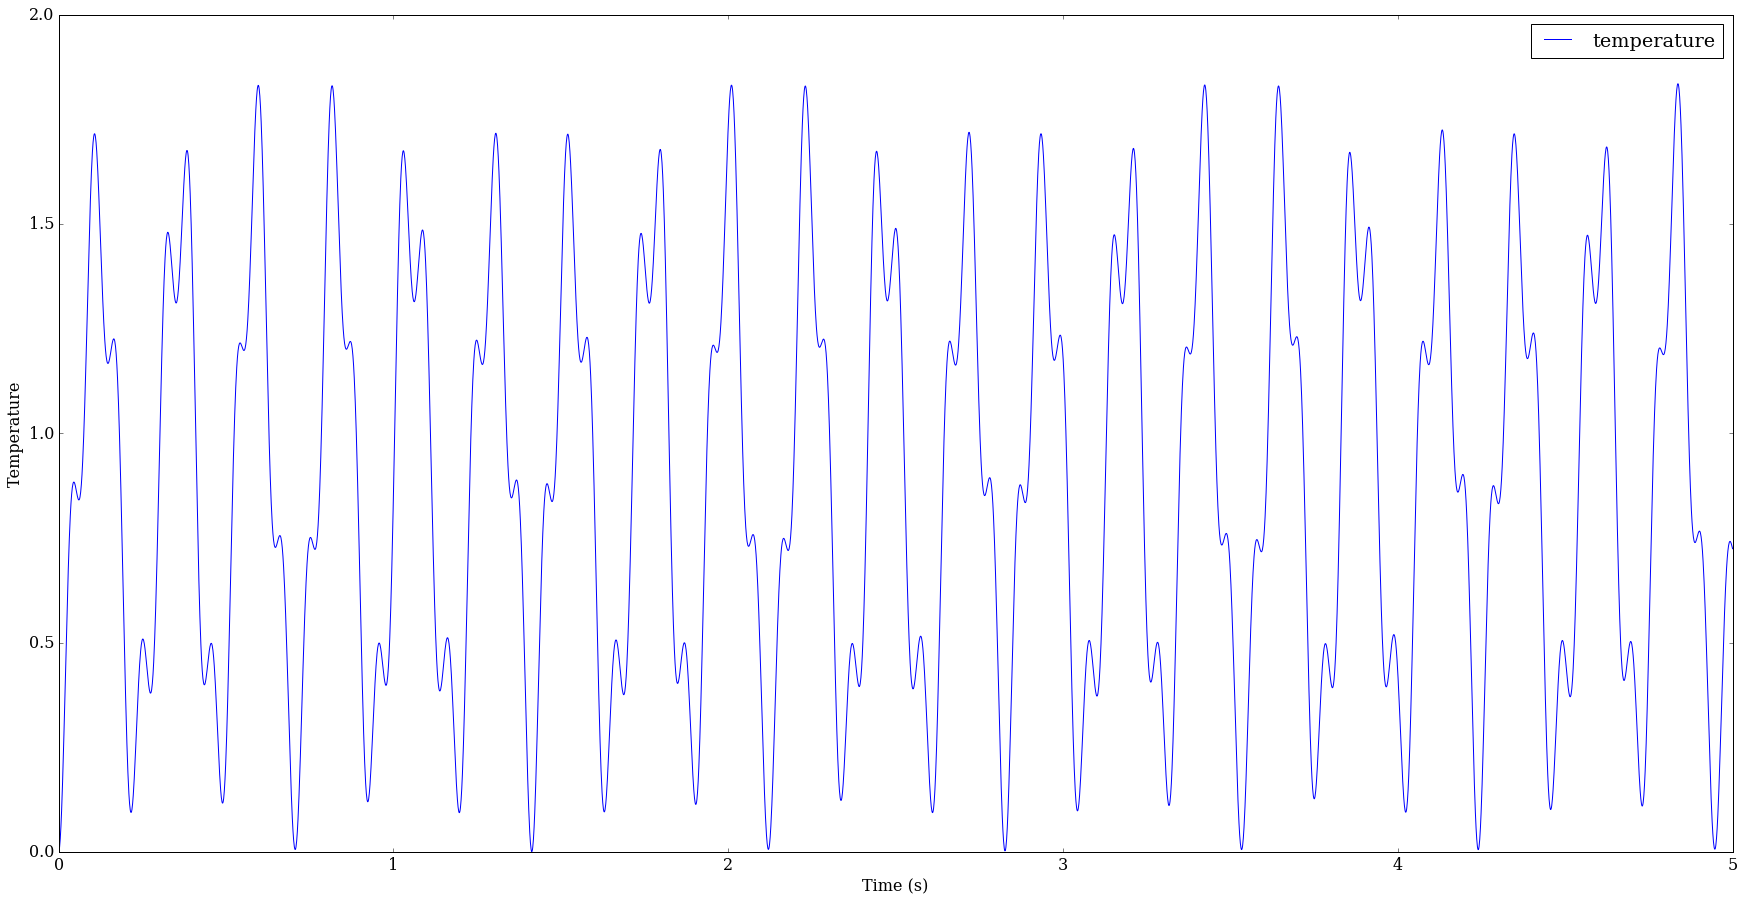

In [232]:
#system's temperature evolution plot
#get the time period for x axis
#%matplotlib inline
x_ax = np.linspace(0, t, steps_no)
plt.plot(x_ax, temperatures, label="temperature")
plt.xlabel("Time (s)")
plt.ylabel("Temperature")
plt.legend()

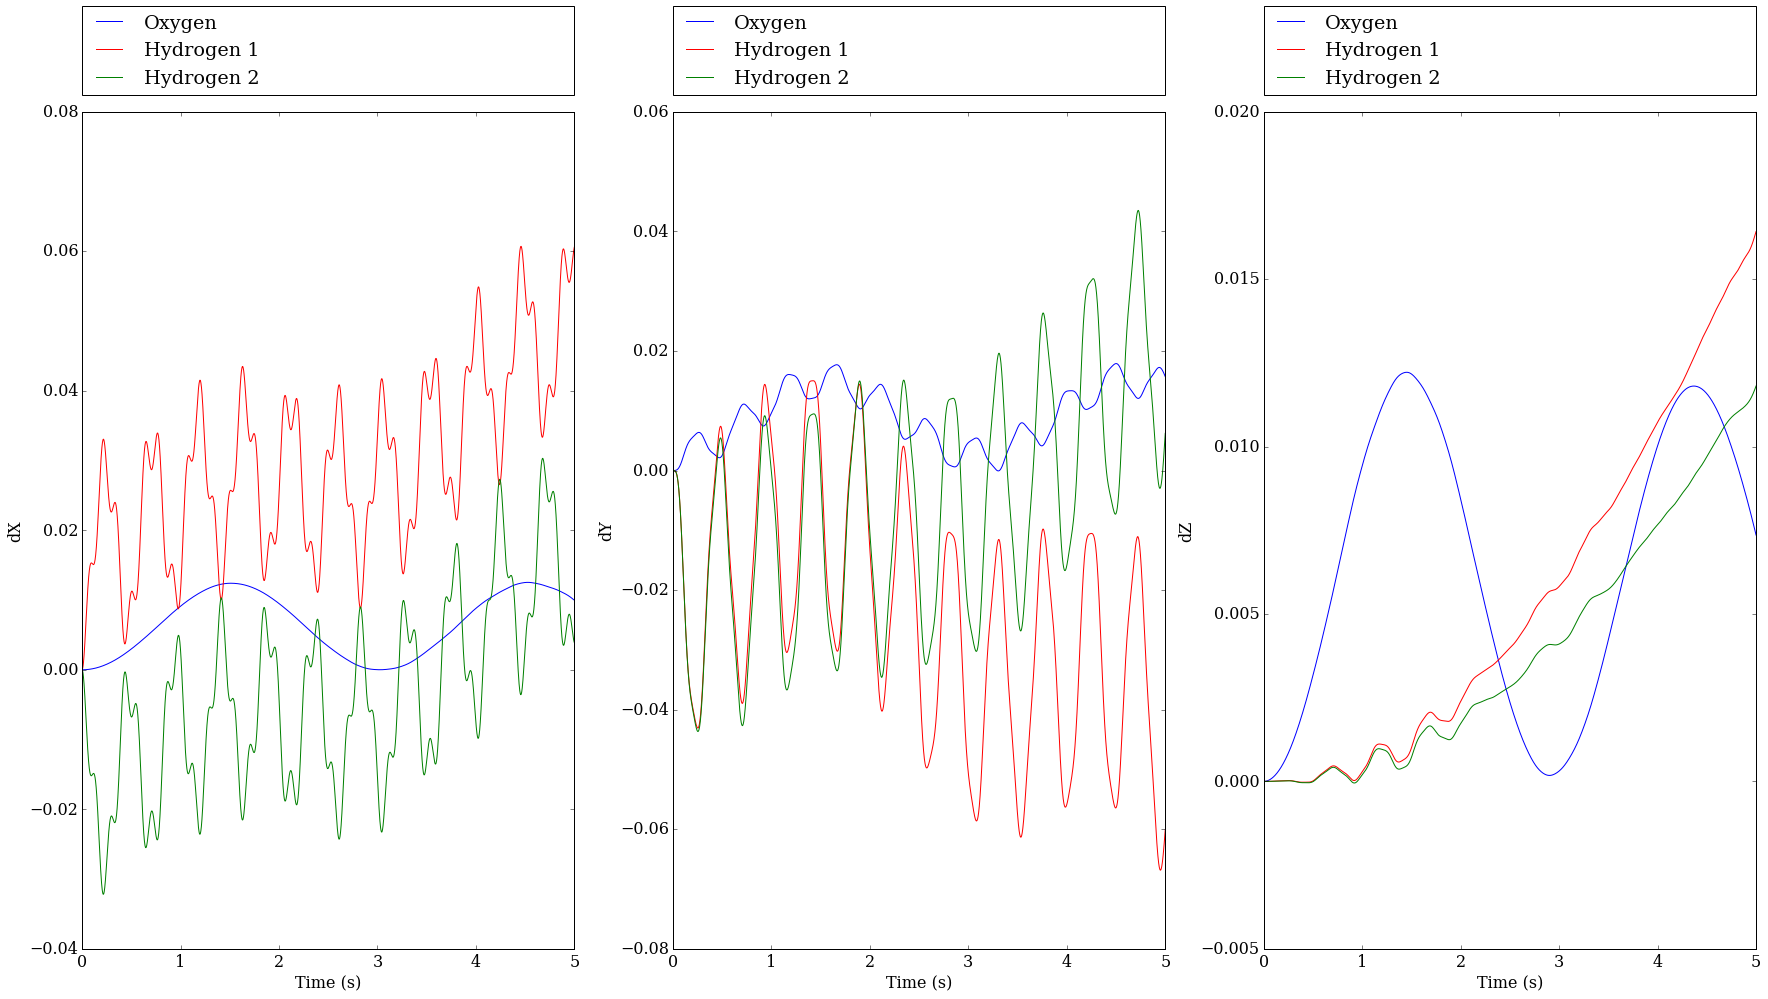

In [233]:
"""2d plots for the relative movement of the atoms in the FIRST molecule."""

#get the time period for x axis
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#plot the X axis evolution of FIRST molecule
ax1 = fig.add_subplot(131)
ax1.plot(x_ax, positions[:, 0, 0] - positions[0, 0, 0], 'b', label="Oxygen")
ax1.plot(x_ax, positions[:, 1, 0] - positions[0, 1, 0], 'r', label="Hydrogen 1")
ax1.plot(x_ax, positions[:, 2, 0] - positions[0, 2, 0], 'g', label="Hydrogen 2")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("dX")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

#plot the Y axis evolution of FIRST molecule
ax2 = fig.add_subplot(132)
ax2.plot(x_ax, positions[:, 0, 1] - positions[0, 0, 1], 'b', label="Oxygen")
ax2.plot(x_ax, positions[:, 1, 1] - positions[0, 1, 1], 'r', label="Hydrogen 1")
ax2.plot(x_ax, positions[:, 2, 1] - positions[0, 2, 1], 'g', label="Hydrogen 2")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("dY")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

#plot the Z axis evolution of FIRST molecule
ax3 = fig.add_subplot(133)
ax3.plot(x_ax, positions[:, 0, 2] - positions[0, 0, 2], 'b', label="Oxygen")
ax3.plot(x_ax, positions[:, 1, 2] - positions[0, 1, 2], 'r', label="Hydrogen 1")
ax3.plot(x_ax, positions[:, 2, 2] - positions[0, 2, 2], 'g', label="Hydrogen 2")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("dZ")
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

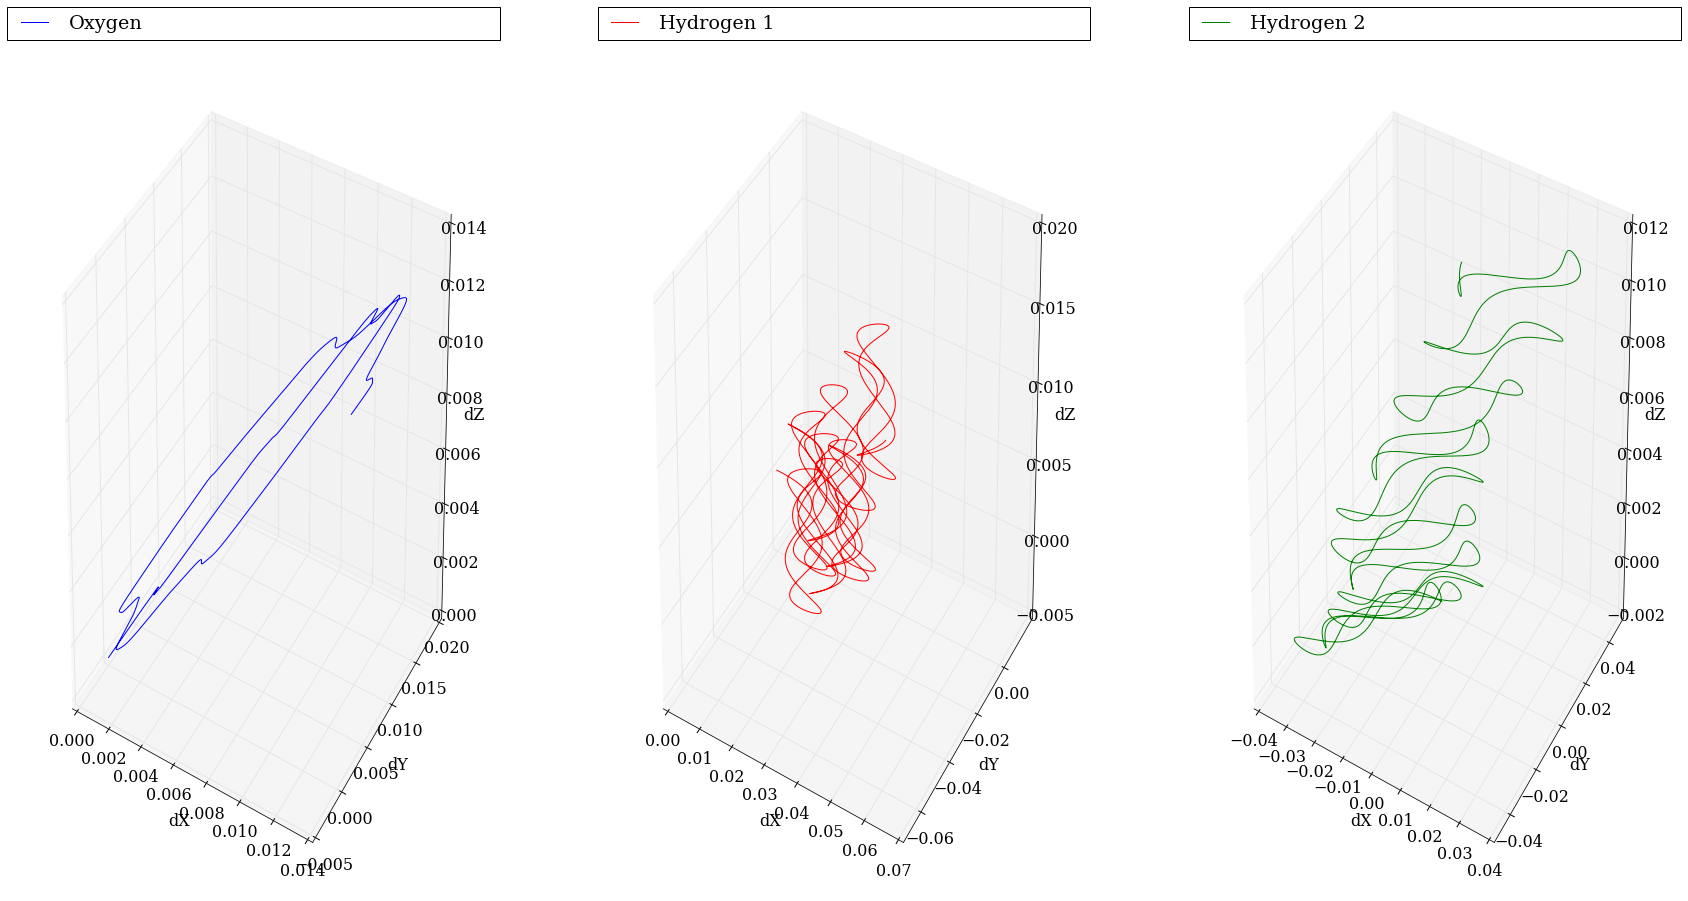

In [234]:
"""3D movement plots for the atoms in the FIRST molecule."""

#get the time period for x axis
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#%matplotlib notebook
#plot the X axis evolution of the OXYGEN atom for the FIRST molecule
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(positions[:, 0, 0] - positions[0, 0, 0], positions[:, 0, 1] - positions[0, 0, 1], positions[:, 0, 2] - positions[0, 0, 2], 'b', label="Oxygen")
ax1.set_xlabel("dX")
ax1.set_ylabel("dY")
ax1.set_zlabel("dZ")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

#plot the Y axis evolution of the FIRST HYDROGEN atom for the FIRST molecule
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(positions[:, 1, 0] - positions[0, 1, 0], positions[:, 1, 1] - positions[0, 1, 1], positions[:, 1, 2] - positions[0, 1, 2], 'r', label="Hydrogen 1")
ax2.set_xlabel("dX")
ax2.set_ylabel("dY")
ax2.set_zlabel("dZ")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

#plot the Z axis evolution of the SECOND HYDROGEN atom for theFIRST molecule
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot(positions[:, 2, 0] - positions[0, 2, 0], positions[:, 2, 1] - positions[0, 2, 1], positions[:, 2, 2] - positions[0, 2, 2], 'g', label="Hydrogen 2")
ax3.set_xlabel("dX")
ax3.set_ylabel("dY")
ax3.set_zlabel("dZ")
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

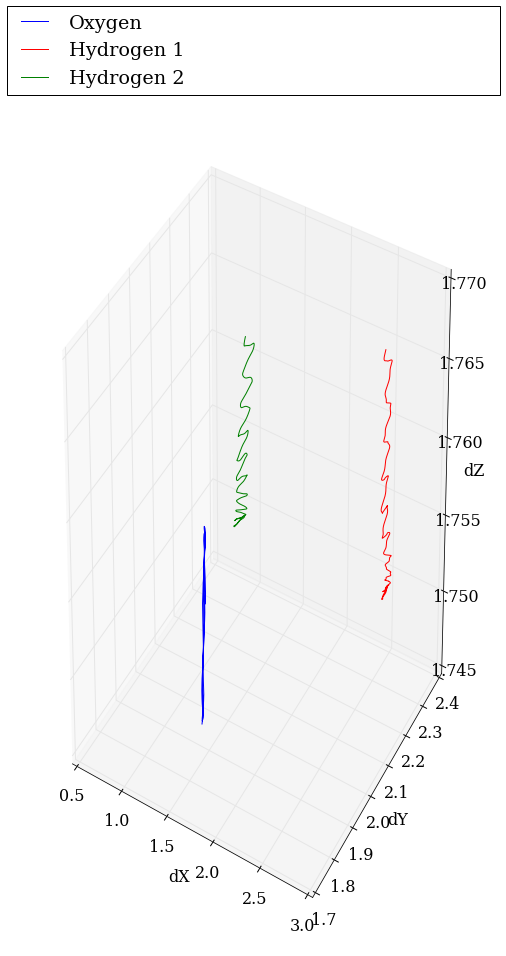

In [185]:
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#plot the evolution of the first mocule of water
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(positions[:, 0, 0] , positions[:, 0, 1], positions[:, 0, 2] , 'b', label="Oxygen")
ax1.plot(positions[:, 1, 0] , positions[:, 1, 1], positions[:, 1, 2] , 'r', label="Hydrogen 1")
ax1.plot(positions[:, 2, 0] , positions[:, 2, 1], positions[:, 2, 2] , 'g', label="Hydrogen 2")

ax1.set_xlabel("dX")
ax1.set_ylabel("dY")
ax1.set_zlabel("dZ")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

### Data plotting for no external forces in the system

In [110]:
#get the number of steps for the simulation
t = 5
steps_no = int(t / dt) #get the step count

#run the main simulation
positions_noext, temperatures_noext = main_simulation(steps_no, external=0)


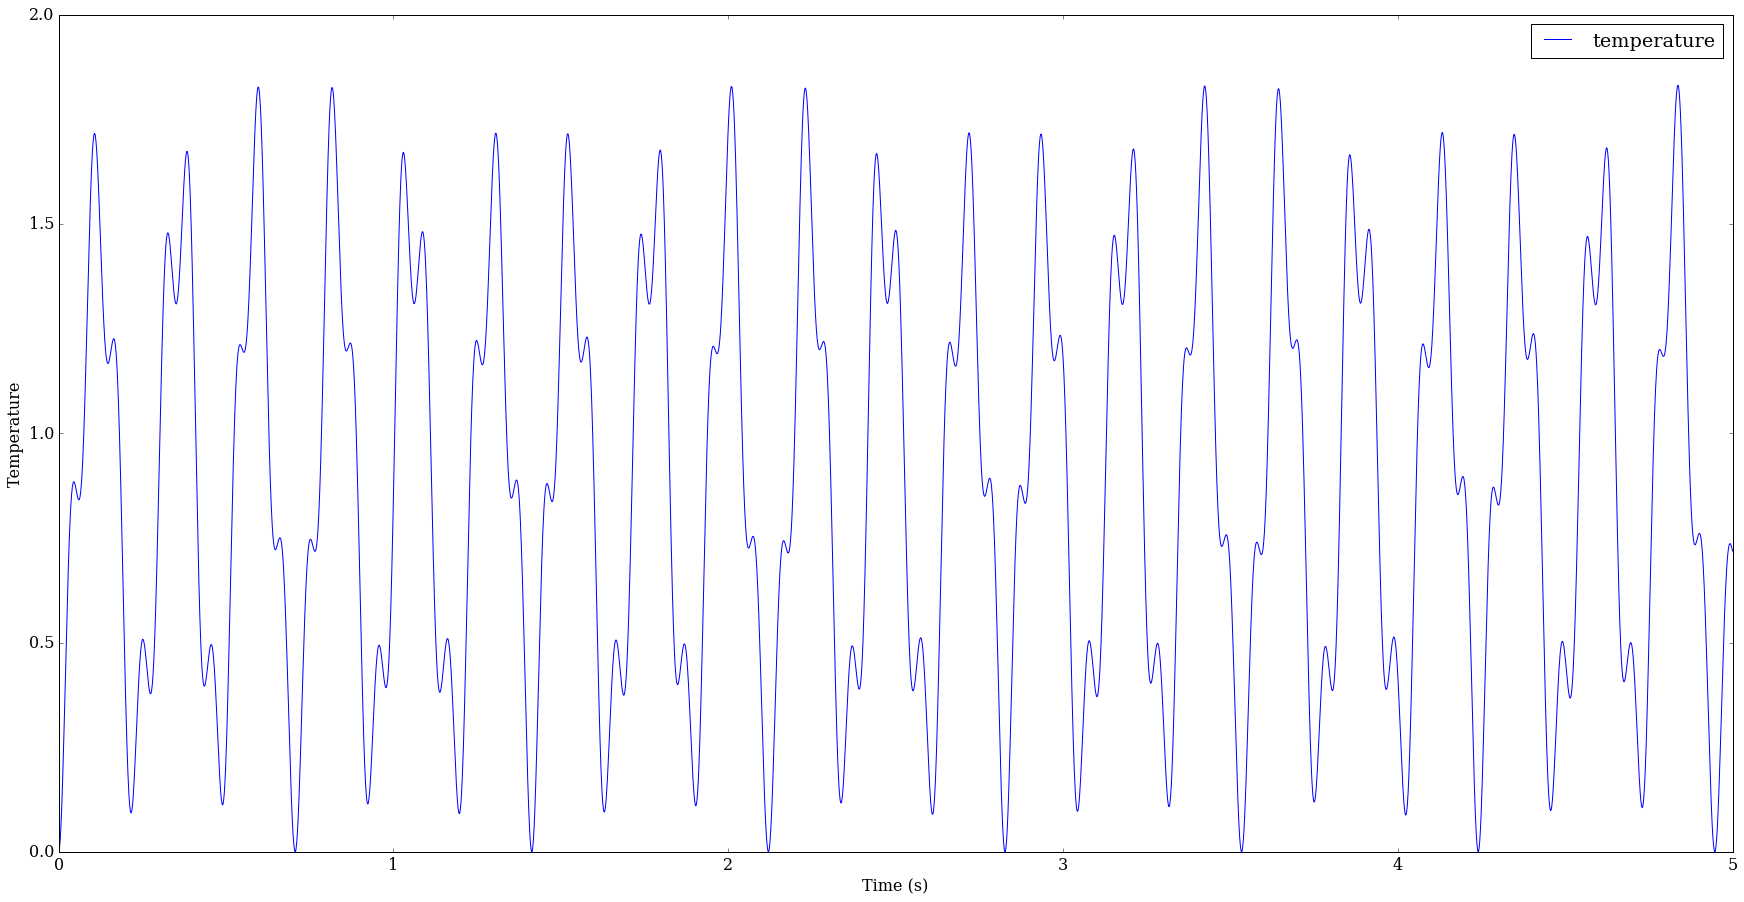

In [112]:
#system's temperature evolution plot
#get the time period for x axis
#%matplotlib inline
x_ax = np.linspace(0, t, steps_no)
plt.plot(x_ax, temperatures_noext, label="temperature")
plt.xlabel("Time (s)")
plt.ylabel("Temperature")
plt.legend()

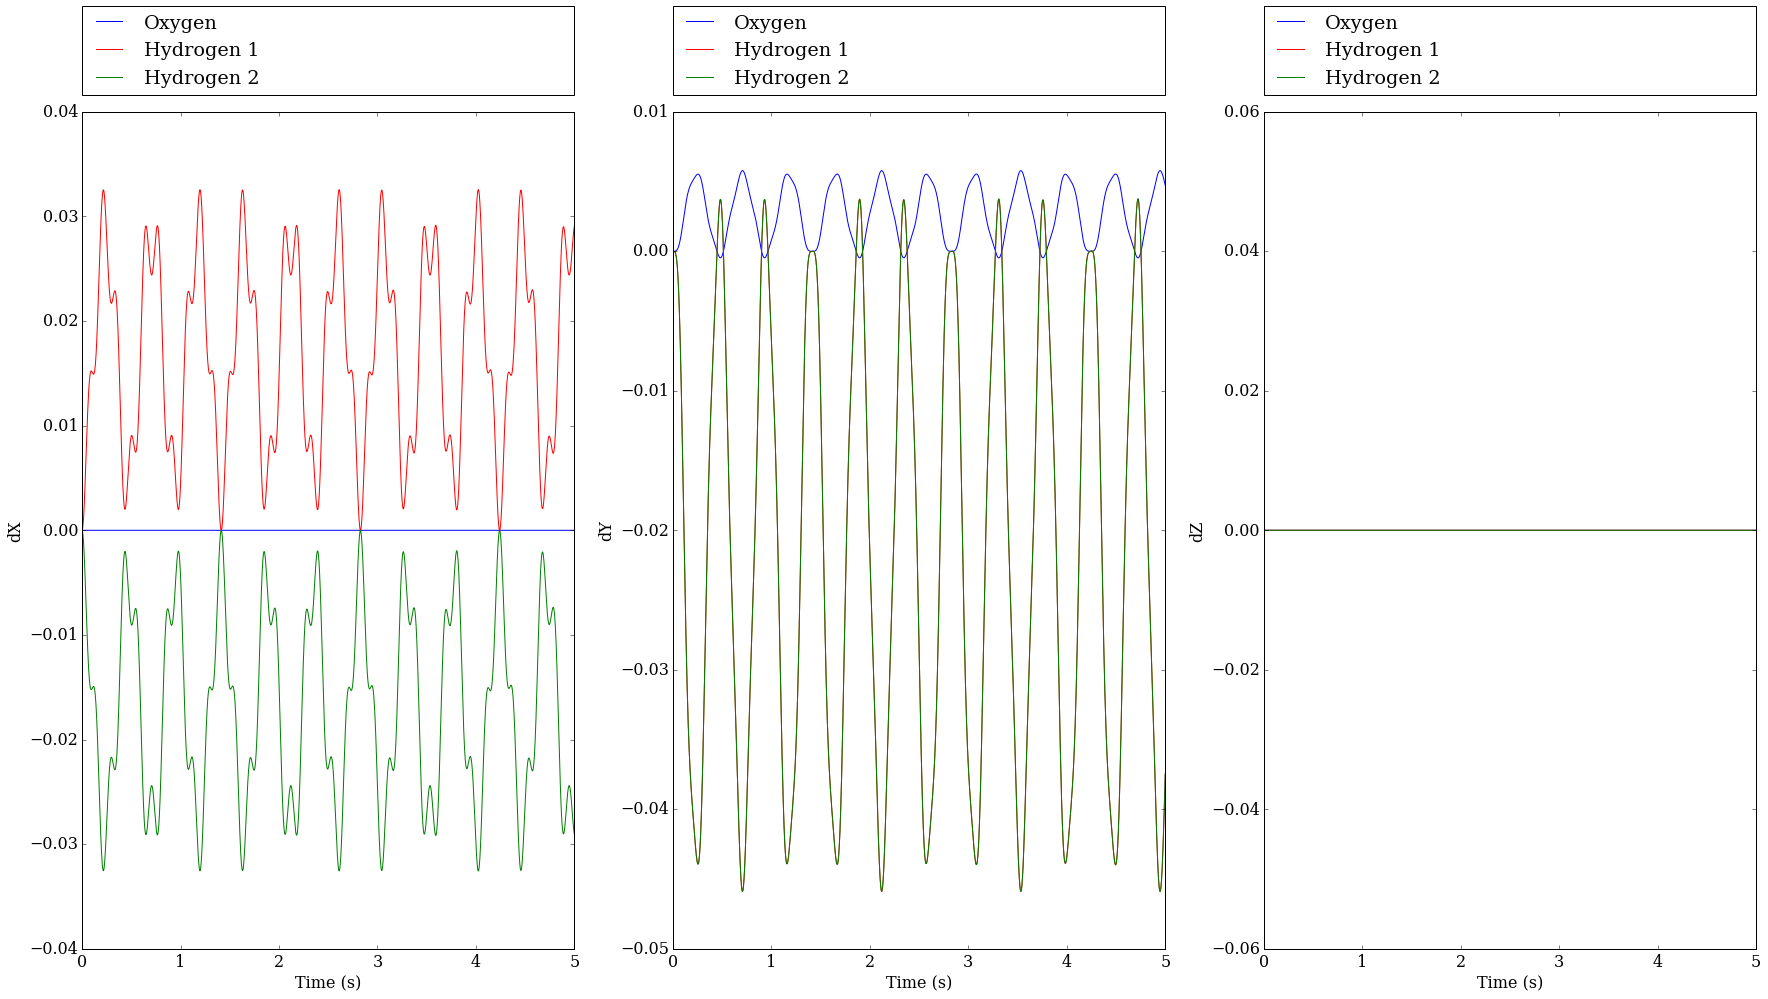

In [117]:
"""2d plots for the relative movement of the atoms in the FIRST molecule."""

#get the time period for x axis
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#plot the X axis evolution of FIRST molecule
ax1 = fig.add_subplot(131)
ax1.plot(x_ax, positions_noext[:, 0, 0] - positions_noext[0, 0, 0], 'b', label="Oxygen")
ax1.plot(x_ax, positions_noext[:, 1, 0] - positions_noext[0, 1, 0], 'r', label="Hydrogen 1")
ax1.plot(x_ax, positions_noext[:, 2, 0] - positions_noext[0, 2, 0], 'g', label="Hydrogen 2")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("dX")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

#plot the Y axis evolution of FIRST molecule
ax2 = fig.add_subplot(132)
ax2.plot(x_ax, positions_noext[:, 0, 1] - positions_noext[0, 0, 1], 'b', label="Oxygen")
ax2.plot(x_ax, positions_noext[:, 1, 1] - positions_noext[0, 1, 1], 'r', label="Hydrogen 1")
ax2.plot(x_ax, positions_noext[:, 2, 1] - positions_noext[0, 2, 1], 'g', label="Hydrogen 2")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("dY")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

#plot the Z axis evolution of FIRST molecule
ax3 = fig.add_subplot(133)
ax3.plot(x_ax, positions_noext[:, 0, 2] - positions_noext[0, 0, 2], 'b', label="Oxygen")
ax3.plot(x_ax, positions_noext[:, 1, 2] - positions_noext[0, 1, 2], 'r', label="Hydrogen 1")
ax3.plot(x_ax, positions_noext[:, 2, 2] - positions_noext[0, 2, 2], 'g', label="Hydrogen 2")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("dZ")
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

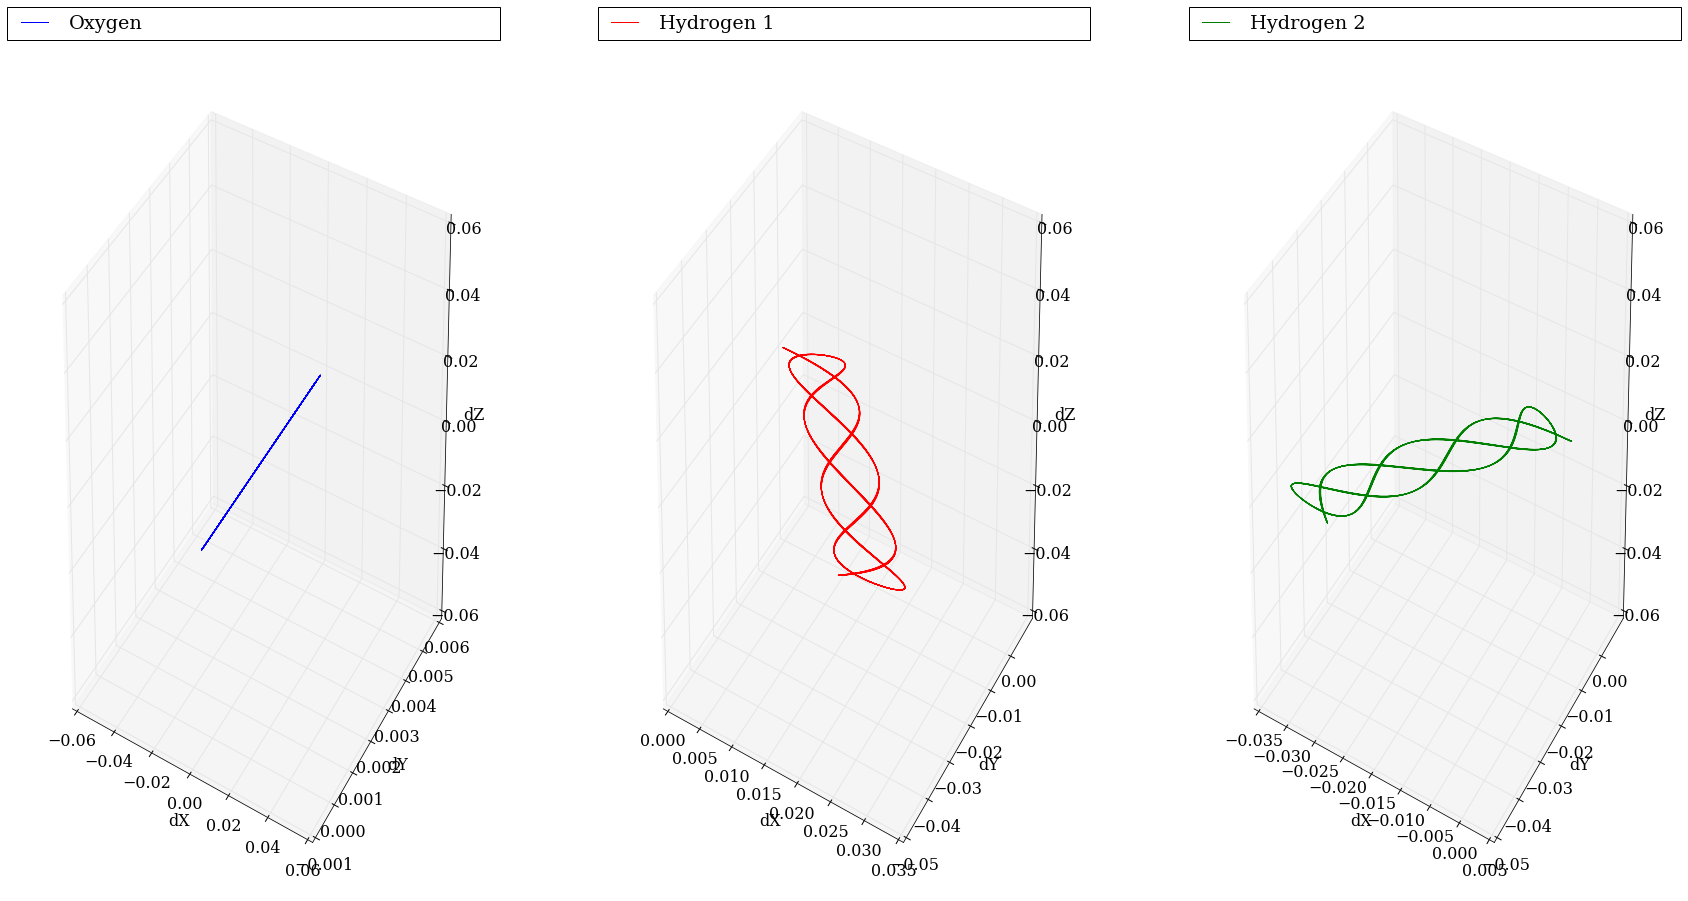

In [119]:
"""3D movement plots for the atoms in the FIRST molecule."""

#get the time period for x axis
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#%matplotlib notebook
#plot the X axis evolution of the OXYGEN atom for the FIRST molecule
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(positions_noext[:, 0, 0] - positions_noext[0, 0, 0], positions_noext[:, 0, 1] - positions_noext[0, 0, 1], positions_noext[:, 0, 2] - positions_noext[0, 0, 2], 'b', label="Oxygen")
ax1.set_xlabel("dX")
ax1.set_ylabel("dY")
ax1.set_zlabel("dZ")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

#plot the Y axis evolution of the FIRST HYDROGEN atom for the FIRST molecule
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(positions_noext[:, 1, 0] - positions_noext[0, 1, 0], positions_noext[:, 1, 1] - positions_noext[0, 1, 1], positions_noext[:, 1, 2] - positions_noext[0, 1, 2], 'r', label="Hydrogen 1")
ax2.set_xlabel("dX")
ax2.set_ylabel("dY")
ax2.set_zlabel("dZ")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

#plot the Z axis evolution of the SECOND HYDROGEN atom for theFIRST molecule
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot(positions_noext[:, 2, 0] - positions_noext[0, 2, 0], positions_noext[:, 2, 1] - positions_noext[0, 2, 1], positions_noext[:, 2, 2] - positions_noext[0, 2, 2], 'g', label="Hydrogen 2")
ax3.set_xlabel("dX")
ax3.set_ylabel("dY")
ax3.set_zlabel("dZ")
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

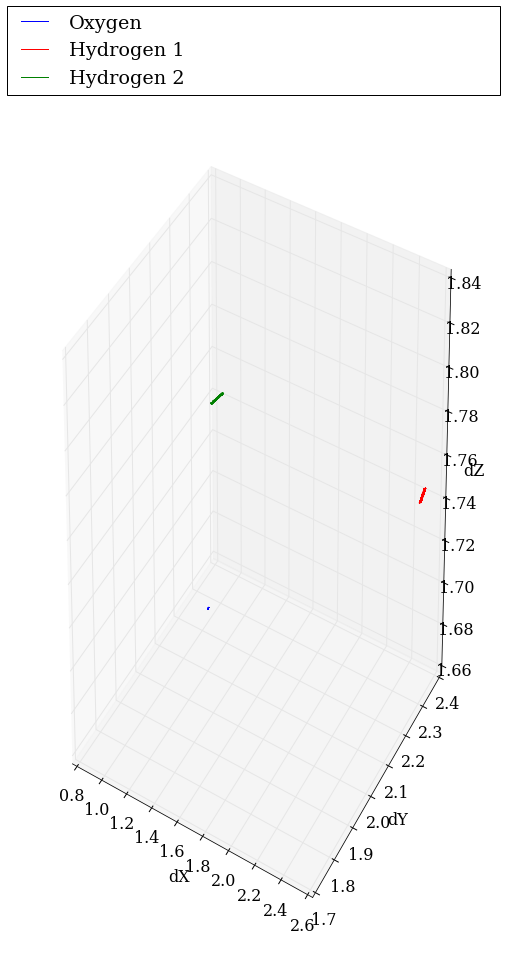

In [121]:
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#plot the evolution of the first mocule of water
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(positions_noext[:, 0, 0] , positions_noext[:, 0, 1], positions_noext[:, 0, 2] , 'b', label="Oxygen")
ax1.plot(positions_noext[:, 1, 0] , positions_noext[:, 1, 1], positions_noext[:, 1, 2] , 'r', label="Hydrogen 1")
ax1.plot(positions_noext[:, 2, 0] , positions_noext[:, 2, 1], positions_noext[:, 2, 2] , 'g', label="Hydrogen 2")

ax1.set_xlabel("dX")
ax1.set_ylabel("dY")
ax1.set_zlabel("dZ")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

### Data plotting for no internal forces in the system

In [171]:
#get the number of steps for the simulation
t = 5
steps_no = int(t / dt) #get the step count

#run the main simulation
positions_noint, temperatures_noint = main_simulation(steps_no, internal=0)


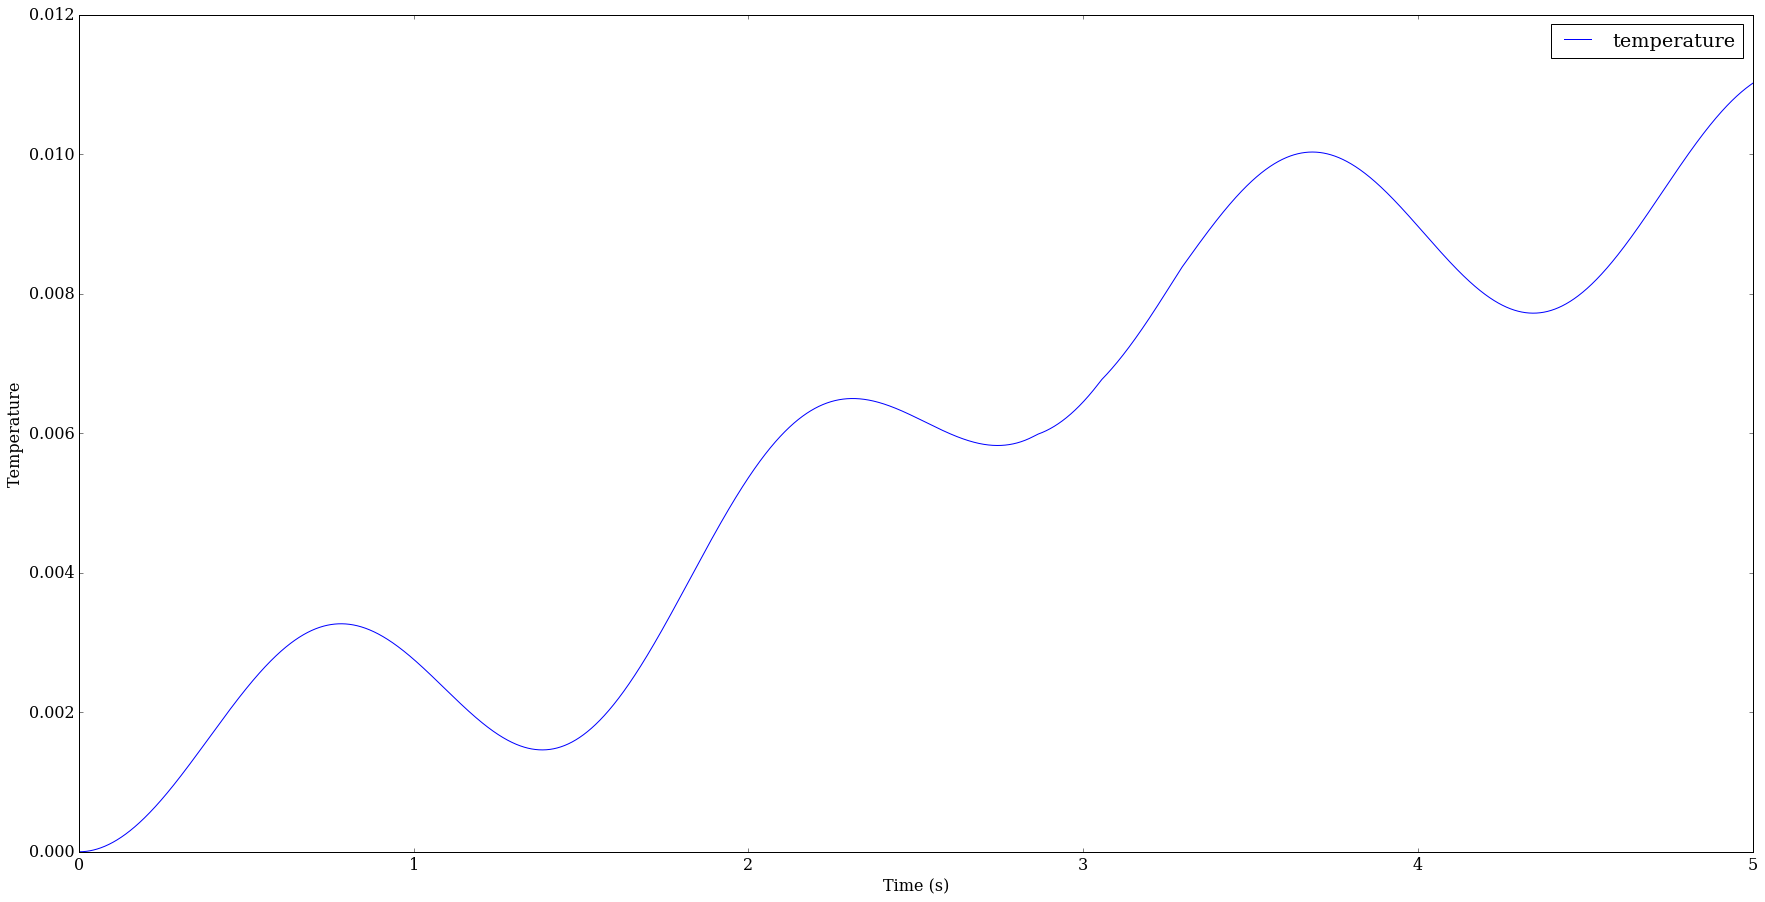

In [172]:
#system's temperature evolution plot
#get the time period for x axis
#%matplotlib inline
x_ax = np.linspace(0, t, steps_no)
plt.plot(x_ax, temperatures_noint, label="temperature")
plt.xlabel("Time (s)")
plt.ylabel("Temperature")
plt.legend()

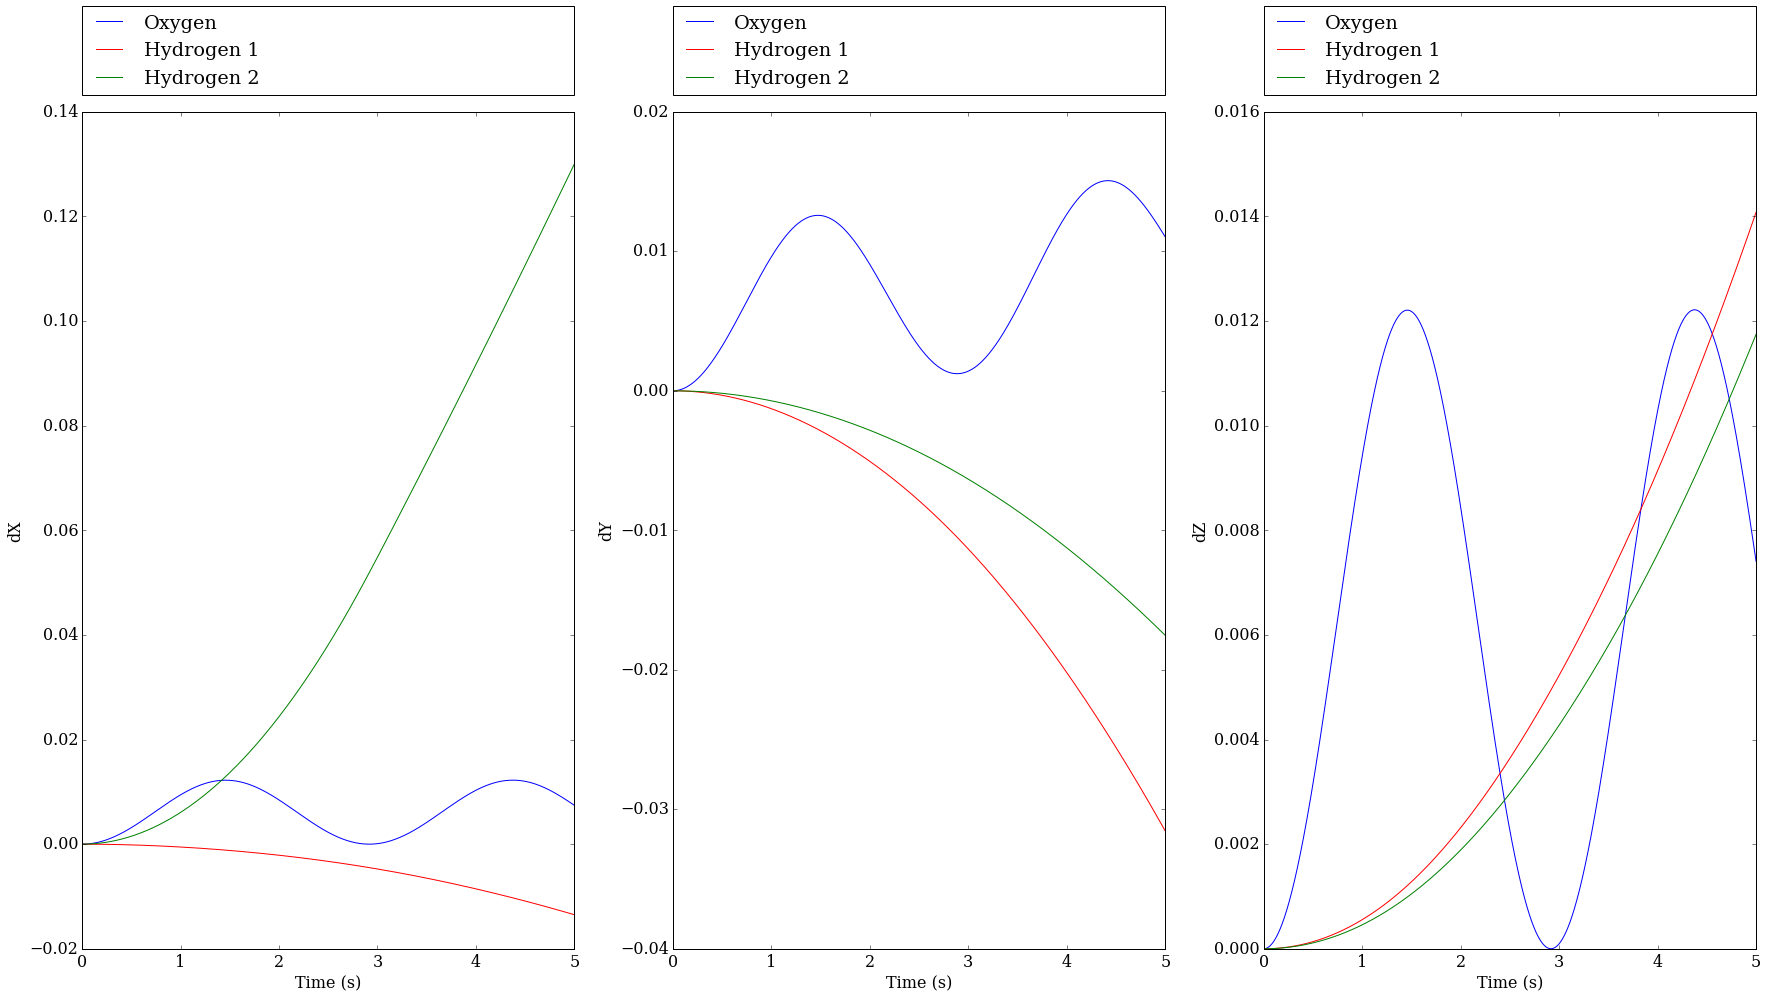

In [173]:
"""2d plots for the relative movement of the atoms in the FIRST molecule."""

#get the time period for x axis
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#plot the X axis evolution of FIRST molecule
ax1 = fig.add_subplot(131)
ax1.plot(x_ax, positions_noint[:, 0, 0] - positions_noint[0, 0, 0], 'b', label="Oxygen")
ax1.plot(x_ax, positions_noint[:, 1, 0] - positions_noint[0, 1, 0], 'r', label="Hydrogen 1")
ax1.plot(x_ax, positions_noint[:, 2, 0] - positions_noint[0, 2, 0], 'g', label="Hydrogen 2")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("dX")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

#plot the Y axis evolution of FIRST molecule
ax2 = fig.add_subplot(132)
ax2.plot(x_ax, positions_noint[:, 0, 1] - positions_noint[0, 0, 1], 'b', label="Oxygen")
ax2.plot(x_ax, positions_noint[:, 1, 1] - positions_noint[0, 1, 1], 'r', label="Hydrogen 1")
ax2.plot(x_ax, positions_noint[:, 2, 1] - positions_noint[0, 2, 1], 'g', label="Hydrogen 2")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("dY")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

#plot the Z axis evolution of FIRST molecule
ax3 = fig.add_subplot(133)
ax3.plot(x_ax, positions_noint[:, 0, 2] - positions_noint[0, 0, 2], 'b', label="Oxygen")
ax3.plot(x_ax, positions_noint[:, 1, 2] - positions_noint[0, 1, 2], 'r', label="Hydrogen 1")
ax3.plot(x_ax, positions_noint[:, 2, 2] - positions_noint[0, 2, 2], 'g', label="Hydrogen 2")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("dZ")
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

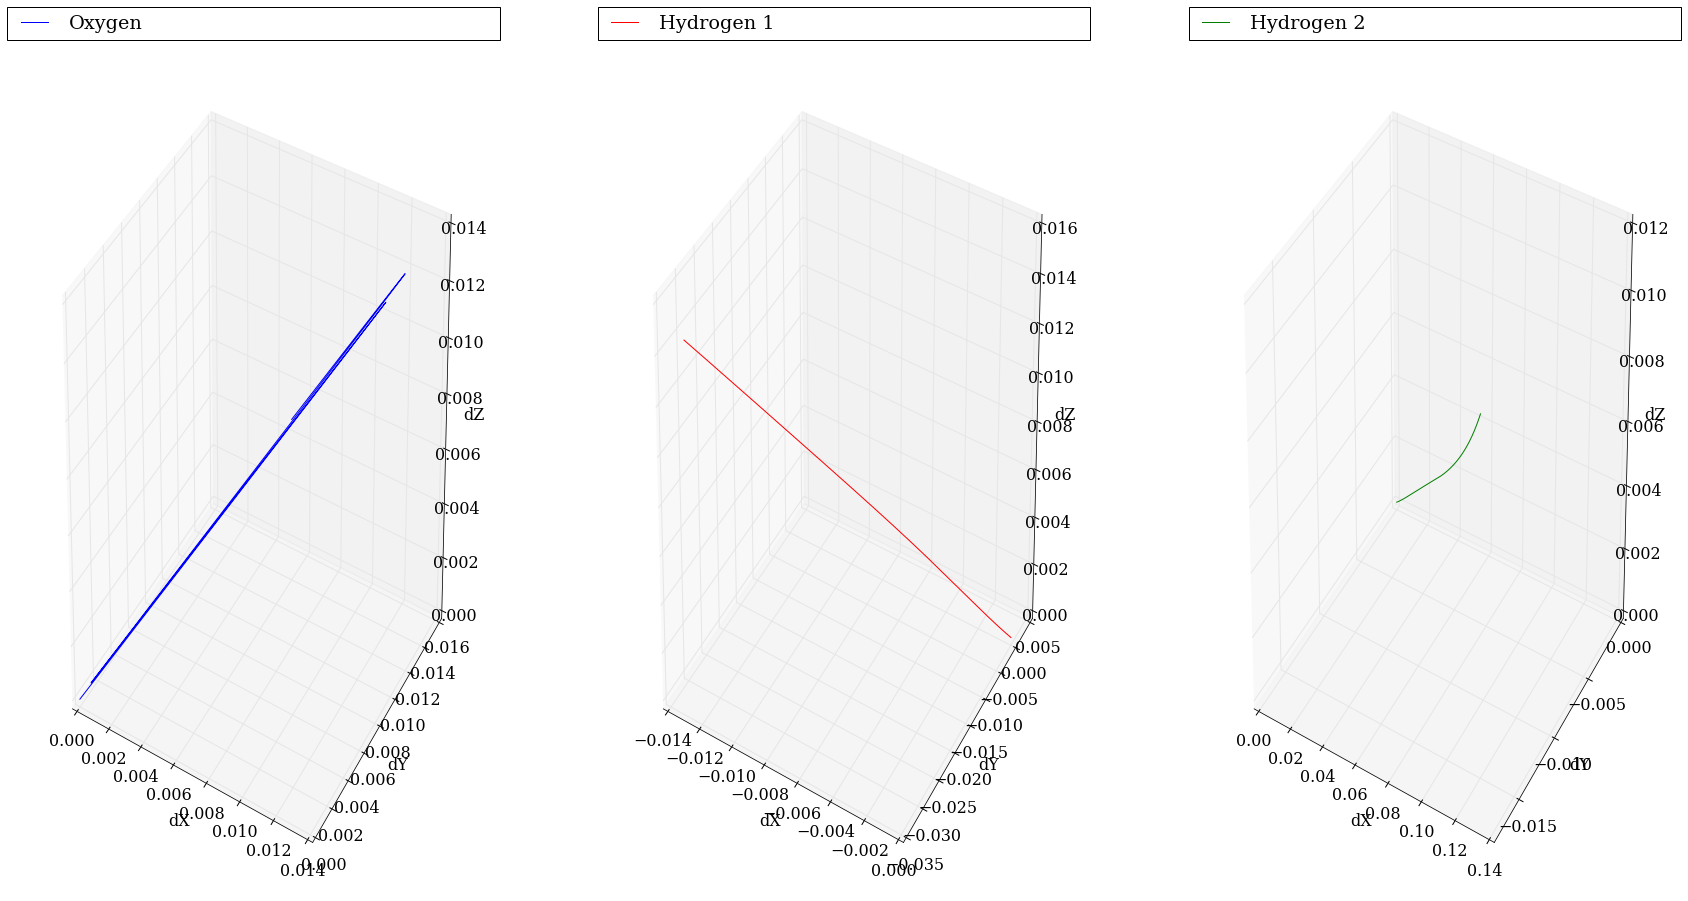

In [174]:
"""3D movement plots for the atoms in the FIRST molecule."""

#get the time period for x axis
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#%matplotlib notebook
#plot the X axis evolution of the OXYGEN atom for the FIRST molecule
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(positions_noint[:, 0, 0] - positions_noint[0, 0, 0], positions_noint[:, 0, 1] - positions_noint[0, 0, 1], positions_noint[:, 0, 2] - positions_noint[0, 0, 2], 'b', label="Oxygen")
ax1.set_xlabel("dX")
ax1.set_ylabel("dY")
ax1.set_zlabel("dZ")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

#plot the Y axis evolution of the FIRST HYDROGEN atom for the FIRST molecule
ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(positions_noint[:, 1, 0] - positions_noint[0, 1, 0], positions_noint[:, 1, 1] - positions_noint[0, 1, 1], positions_noint[:, 1, 2] - positions_noint[0, 1, 2], 'r', label="Hydrogen 1")
ax2.set_xlabel("dX")
ax2.set_ylabel("dY")
ax2.set_zlabel("dZ")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

#plot the Z axis evolution of the SECOND HYDROGEN atom for theFIRST molecule
ax3 = fig.add_subplot(133, projection="3d")
ax3.plot(positions_noint[:, 2, 0] - positions_noint[0, 2, 0], positions_noint[:, 2, 1] - positions_noint[0, 2, 1], positions_noint[:, 2, 2] - positions_noint[0, 2, 2], 'g', label="Hydrogen 2")
ax3.set_xlabel("dX")
ax3.set_ylabel("dY")
ax3.set_zlabel("dZ")
ax3.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)

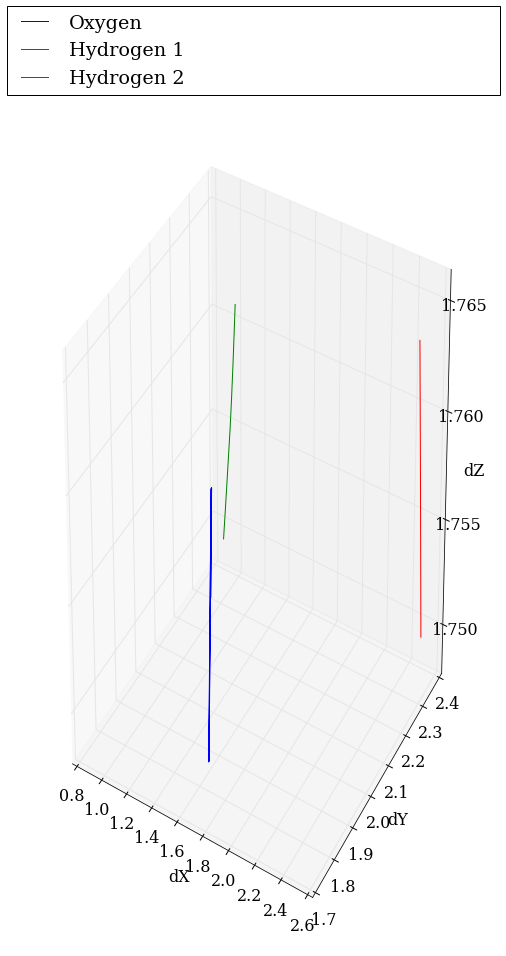

In [175]:
x_ax = np.linspace(0, t, steps_no)

fig = plt.figure()

#plot the evolution of the first mocule of water
ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(positions_noint[:, 0, 0] , positions_noint[:, 0, 1], positions_noint[:, 0, 2] , 'b', label="Oxygen")
ax1.plot(positions_noint[:, 1, 0] , positions_noint[:, 1, 1], positions_noint[:, 1, 2] , 'r', label="Hydrogen 1")
ax1.plot(positions_noint[:, 2, 0] , positions_noint[:, 2, 1], positions_noint[:, 2, 2] , 'g', label="Hydrogen 2")

ax1.set_xlabel("dX")
ax1.set_ylabel("dY")
ax1.set_zlabel("dZ")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, ncol=1, mode="expand", borderaxespad=0.)

### Discussion

This simulation provides critical insight in the dynamics of water molecules an their evolution in time. In order to obtain the motion of each atom, a step by step integration of the position, velocity and acceleration has conducted, using a 0.001s timestep. The acceleration was computed using the force exerted on each atom by the other atoms, as the sum of internal forces (in the same molecule) and external forces (forces exerted by atoms from other molecules). 
In addition, each force was computed as the derivative of respetive potential. 
Finally, the overall "temperature of the system" was computed relative to the kinetic energy of the system.

Several results were observed in these simulations. Firstly, regarding the overall temperature of the system, it can be observed that it stays relatively stable. Two osciallating frequencies can be observed, one at ~5Hz and one at ~14Hz. These are mainly due to the system oscillating around stable position (returning to 0), as it has not started in the stable position. However, it can be seen that due to external forces, there is a slight rise in the overall temperature of the system (0.01 degrees), implying that there might be a divergence from equilibrium (creating energy from nothing). This is  mainly due to floating point error. Lastly, it can be observed that the internal forces between atoms represent the main factor in the system's temperature. 

Regarding the position of the particles, general osciallations can be observed. Again, as the system did not start in the stable position for the distance between each particle, the system will oscillate. It can be observed that for the simulation period, the internal forces define a oscillatory movement around stable position (oxygen-hydrogen at 1Å and hydrogen-hydrogen at 1.633Å). This is the main component of the motion of the hydrogen atoms. However, the external forces dominate the movement of the oxygen atoms; again, creating an oscillatory motion around the initial position. However, for the hydrogen atoms, the external forces create a divergece from stable oscillatory position on all axis. This behaviour has been concluded to be caused by floating point and rounding errors in the simulation. This method is extremely sensible to the number of significant figures used. Lastly, the position of the atoms is affected by the external forces also in response to the suboptimal positioning of the atoms. The overall lattice is formed from just 8 molecules, all with the same orientation. As such, the system will eventually trend towards the stable position of this configuration.

In conclusion, the internal forces, created by the potential gradient, are the main factor for the temperature oscillation and for the movement of the hydrogen atoms. The external forces, although they also affect the motion of the hydrogen atoms, they are the main contributor to the movement of the oxygen atoms.